In [ ]:
import pandas
!pip install statsmodels pandas


In [ ]:
!pip install statsmodels


In [ ]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen


In [ ]:
import numpy as np


In [ ]:
!pip install pandas-datareader --upgrade

In [ ]:
!pip install yfinance --upgrade --quiet

In [ ]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data
from datetime import datetime

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Access data from yahoo finance


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Forex pairs
pairs = [
    'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'AUDUSD=X', 'USDCAD=X', 'USDCHF=X', 'NZDUSD=X',
    'EURGBP=X', 'EURJPY=X', 'EURAUD=X', 'EURCAD=X', 'EURCHF=X', 'EURNZD=X',
    'GBPJPY=X', 'GBPAUD=X', 'GBPCAD=X', 'GBPCHF=X', 'GBPNZD=X',
    'AUDJPY=X', 'AUDNZD=X', 'AUDCAD=X', 'AUDCHF=X',
    'CADJPY=X', 'CHFJPY=X', 'NZDJPY=X', 'NZDCAD=X', 'NZDCHF=X'
]

# Download data
data = yf.download(pairs, start='2010-01-01', end='2025-10-10')['Close']


/tmp/ipython-input-2419982539.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(pairs, start='2010-01-01', end='2025-10-10')['Close']
[*********************100%***********************]  27 of 27 completed


#Main selection of pairs

In [ ]:
returns = data.pct_change().dropna()

/tmp/ipython-input-1517689983.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


In [ ]:
# Parameters
window = 20          # rolling window size
top_n = 2            # number of top correlated pairs
threshold = 0.8      # strong correlation threshold

# -----------------------
# Step 1: Compute rolling correlations (dynamic)
# -----------------------
top_corr_results = []

for date in returns.index[window:]:
    window_data = returns.loc[returns.index <= date].iloc[-window:]
    corr_matrix = window_data.corr()

    for base_pair in corr_matrix.columns:
        sorted_corrs = corr_matrix[base_pair].drop(base_pair).sort_values(ascending=False)
        top2 = sorted_corrs.head(top_n)
        top_corr_results.append({
            "date": date,
            "base_pair": base_pair,
            "pair_1": top2.index[0],
            "corr_1": top2.iloc[0],
            "pair_2": top2.index[1],
            "corr_2": top2.iloc[1]
        })

top_corr_df = pd.DataFrame(top_corr_results)

# -----------------------
# Step 2: Frequency summary
# -----------------------
most_common_pairs = {}
for pair in returns.columns:
    subset = top_corr_df[top_corr_df["base_pair"] == pair]
    pair1_counts = subset["pair_1"].value_counts()
    pair2_counts = subset["pair_2"].value_counts()
    combined = (pair1_counts + pair2_counts).sort_values(ascending=False)
    most_common_pairs[pair] = combined.head(top_n)

# -----------------------
# Step 3: Max duration of strong correlation
# -----------------------
def max_duration_strong_corr(series, threshold=0.8):
    max_dur = pd.Timedelta(0)
    in_state = False
    start_time = None
    for time, val in series.items():
        if abs(val) > threshold:
            if not in_state:
                start_time = time
                in_state = True
        else:
            if in_state:
                duration = time - start_time
                max_dur = max(max_dur, duration)
                in_state = False
    if in_state:
        duration = series.index[-1] - start_time
        max_dur = max(max_dur, duration)
    return max_dur

# Compute max duration for each pair
max_duration_dict = {}
for base in returns.columns:
    durations = {}
    for other in returns.columns:
        if other == base:
            continue
        corr_series = returns[base].rolling(window).corr(returns[other])
        durations[other] = max_duration_strong_corr(corr_series, threshold)
    max_duration_dict[base] = durations

# -----------------------
# Step 4: Merge frequency + average corr + duration
# -----------------------
final_top_pairs = {}
for base, top_pairs in most_common_pairs.items():
    merged_list = []
    for other in top_pairs.index:
        avg_corr = returns[[base, other]].corr().iloc[0,1]
        duration = max_duration_dict[base][other].days  # duration in days
        merged_list.append((other, round(avg_corr,3), duration))
    # Sort by avg_corr then duration
    final_top_pairs[base] = sorted(merged_list, key=lambda x: (x[1], x[2]), reverse=True)

# -----------------------
# Step 5: Print final result
# -----------------------
print(f"Top {top_n} correlated pairs per base pair (freq + avg corr + max duration):")
for base, lst in final_top_pairs.items():
    print(f"{base}: {lst}")


Top 2 correlated pairs per base pair (freq + avg corr + max duration):
AUDCAD=X: [('NZDCAD=X', np.float64(0.713), 211), ('AUDUSD=X', np.float64(0.712), 119)]
AUDCHF=X: [('NZDCHF=X', np.float64(0.854), 426), ('AUDJPY=X', np.float64(0.629), 114)]
AUDJPY=X: [('NZDJPY=X', np.float64(0.874), 605), ('CADJPY=X', np.float64(0.801), 216)]
AUDNZD=X: [('GBPNZD=X', np.float64(0.362), 6), ('EURNZD=X', np.float64(0.35), 18)]
AUDUSD=X: [('NZDUSD=X', np.float64(0.837), 406), ('AUDJPY=X', np.float64(0.691), 114)]
CADJPY=X: [('AUDJPY=X', np.float64(0.801), 216), ('USDJPY=X', np.float64(0.754), 137)]
CHFJPY=X: [('EURJPY=X', np.float64(0.686), 583), ('GBPJPY=X', np.float64(0.55), 158)]
EURAUD=X: [('EURNZD=X', np.float64(0.772), 182), ('GBPAUD=X', np.float64(0.66), 106)]
EURCAD=X: [('EURUSD=X', np.float64(0.603), 55), ('GBPCAD=X', np.float64(0.58), 32)]
EURCHF=X: [('GBPCHF=X', np.float64(0.666), 107), ('AUDCHF=X', np.float64(0.606), 93)]
EURGBP=X: [('EURCAD=X', np.float64(0.379), 34), ('EURUSD=X', np.float

In [ ]:
final_top_pairs = {}
for base, top_pairs in most_common_pairs.items():
    merged_list = []
    for other, freq in top_pairs.items():  # get frequency from the Series
        avg_corr = returns[[base, other]].corr().iloc[0,1]
        duration = max_duration_dict[base][other].days  # duration in days
        merged_list.append((other, freq, round(avg_corr,3), duration))
    # Sort by avg_corr then duration
    final_top_pairs[base] = sorted(merged_list, key=lambda x: (x[2], x[3]), reverse=True)

# Step 5: Print nicely
print(f"Top {top_n} correlated pairs per base pair (freq + avg corr + max duration):")
for base, lst in final_top_pairs.items():
    print(f"{base}:")
    for other, freq, avg_corr, dur in lst:
        print(f"   {other:<10} | Freq: {freq:<3} | Corr: {avg_corr:<5} | Duration: {dur} days")


Top 2 correlated pairs per base pair (freq + avg corr + max duration):
AUDCAD=X:
   NZDCAD=X   | Freq: 2688.0 | Corr: 0.713 | Duration: 211 days
   AUDUSD=X   | Freq: 2931.0 | Corr: 0.712 | Duration: 119 days
AUDCHF=X:
   NZDCHF=X   | Freq: 3184.0 | Corr: 0.854 | Duration: 426 days
   AUDJPY=X   | Freq: 1797.0 | Corr: 0.629 | Duration: 114 days
AUDJPY=X:
   NZDJPY=X   | Freq: 3118.0 | Corr: 0.874 | Duration: 605 days
   CADJPY=X   | Freq: 1560.0 | Corr: 0.801 | Duration: 216 days
AUDNZD=X:
   GBPNZD=X   | Freq: 1844.0 | Corr: 0.362 | Duration: 6 days
   EURNZD=X   | Freq: 1929.0 | Corr: 0.35  | Duration: 18 days
AUDUSD=X:
   NZDUSD=X   | Freq: 3093.0 | Corr: 0.837 | Duration: 406 days
   AUDJPY=X   | Freq: 1503.0 | Corr: 0.691 | Duration: 114 days
CADJPY=X:
   AUDJPY=X   | Freq: 2396.0 | Corr: 0.801 | Duration: 216 days
   USDJPY=X   | Freq: 1897.0 | Corr: 0.754 | Duration: 137 days
CHFJPY=X:
   EURJPY=X   | Freq: 3565.0 | Corr: 0.686 | Duration: 583 days
   GBPJPY=X   | Freq: 1278.0 |

In [ ]:
# Create corr_dict: base pair → top 2 correlated pairs
corr_dict = {}

for base, lst in final_top_pairs.items():
    # Take only the top 2 pairs
    top_pairs = [p[0] for p in lst[:2]]
    corr_dict[base] = top_pairs

# Print the result
for base, top in corr_dict.items():
    print(f"{base}: {top}")


AUDCAD=X: ['NZDCAD=X', 'AUDUSD=X']
AUDCHF=X: ['NZDCHF=X', 'AUDJPY=X']
AUDJPY=X: ['NZDJPY=X', 'CADJPY=X']
AUDNZD=X: ['GBPNZD=X', 'EURNZD=X']
AUDUSD=X: ['NZDUSD=X', 'AUDJPY=X']
CADJPY=X: ['AUDJPY=X', 'USDJPY=X']
CHFJPY=X: ['EURJPY=X', 'GBPJPY=X']
EURAUD=X: ['EURNZD=X', 'GBPAUD=X']
EURCAD=X: ['EURUSD=X', 'GBPCAD=X']
EURCHF=X: ['GBPCHF=X', 'AUDCHF=X']
EURGBP=X: ['EURCAD=X', 'EURUSD=X']
EURJPY=X: ['GBPJPY=X', 'CHFJPY=X']
EURNZD=X: ['EURAUD=X', 'GBPNZD=X']
EURUSD=X: ['GBPUSD=X', 'EURCAD=X']
GBPAUD=X: ['GBPNZD=X', 'EURAUD=X']
GBPCAD=X: ['GBPUSD=X', 'EURCAD=X']
GBPCHF=X: ['USDCHF=X', 'GBPJPY=X']
GBPJPY=X: ['EURJPY=X', 'CADJPY=X']
GBPNZD=X: ['GBPAUD=X', 'EURNZD=X']
GBPUSD=X: ['GBPCAD=X', 'EURUSD=X']
NZDCAD=X: ['NZDUSD=X', 'AUDCAD=X']
NZDCHF=X: ['AUDCHF=X', 'NZDJPY=X']
NZDJPY=X: ['AUDJPY=X', 'NZDUSD=X']
NZDUSD=X: ['AUDUSD=X', 'NZDCAD=X']
USDCAD=X: ['EURCAD=X', 'GBPCAD=X']
USDCHF=X: ['GBPCHF=X', 'USDJPY=X']
USDJPY=X: ['CADJPY=X', 'GBPJPY=X']


#---------------------XXXXX-------------------------

#Systematic input-output for finding initial 3 pairs for a set

In [ ]:
import pandas as pd

def get_top_corr_for_base(final_top_pairs):
    """
    Ask user for a base pair and display top correlated pairs with:
    - Frequency
    - Average correlation
    - Max duration of strong correlation (days)
    """
    base_pair = input("Enter base currency pair (e.g. EURUSD=X): ").strip().upper()

    if base_pair not in final_top_pairs:
        print(f"❌ No data found for '{base_pair}'. Try another base pair.")
        return

    top_pairs = final_top_pairs[base_pair][:2]  # top 2 pairs
    rows = []
    for other, freq, avg_corr, dur in top_pairs:
        rows.append({
            "Base Pair": base_pair,
            "Correlated Pair": other,
            "Frequency": int(freq),
            "Avg Correlation": round(avg_corr,3),
            "Max Duration (days)": dur
        })

    df = pd.DataFrame(rows)
    print(f"\n📊 Top {len(rows)} Correlated Pairs for {base_pair}:\n\t\t")
    print(df.to_string(index=False))

# ✅ Call the function
get_top_corr_for_base(final_top_pairs)


Enter base currency pair (e.g. EURUSD=X): EURUSD=X

📊 Top 2 Correlated Pairs for EURUSD=X:
		
Base Pair Correlated Pair  Frequency  Avg Correlation  Max Duration (days)
 EURUSD=X        GBPUSD=X       1823            0.618                   88
 EURUSD=X        EURCAD=X       1427            0.603                   55


#Find out during time which 3 asset are mostly correlated

#Adf test then decide you will take first difference or not

####Adf test function

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Fill missing values ---
data = data.ffill().bfill()

# --- 2. Compute transformations ---
diff_return = data.diff().dropna()           # First difference
log_return = np.log(data).diff().dropna()    # Log return

# --- 3. ADF test function ---
def adf_test(series, name):
    result = adfuller(series.dropna())
    stat, pvalue = result[0], result[1]
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic: {stat:.4f}")
    print(f"  p-value: {pvalue:.4f}")
    if pvalue < 0.05:
        print("  → Reject H0: Series is stationary")
    else:
        print("  → Fail to reject H0: Series is non-stationary")
    print("-" * 50)
    return stat, pvalue

# --- 4. Loop over batches from corr_dict ---
results = []  # To store all ADF outputs in a DataFrame later

for base, corr_pairs in corr_dict.items():
    batch = [base] + corr_pairs  # 3-pair group
    print("\n" + "=" * 80)
    print(f"ADF Test for Group: {batch}")
    print("=" * 80)

    for col in batch:
        if col not in data.columns:
            print(f"⚠️  {col} not found in dataset, skipping.")
            continue

        # --- Run ADF tests on Price, First Difference, Log Return ---
        for transform_name, series in [
            ("Price", data[col]),
            ("First Difference", diff_return[col]),
            ("Log Return", log_return[col]),
        ]:
            stat, pval = adf_test(series, f"{col} ({transform_name})")

            results.append({
                "base_group": base,
                "pair": col,
                "transform": transform_name,
                "ADF_stat": stat,
                "p_value": pval,
                "stationary": "Yes" if pval < 0.05 else "No"
            })

# --- 5. Convert results to DataFrame ---
adf_results_df = pd.DataFrame(results)




ADF Test for Group: ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']
ADF Test for AUDCAD=X (Price):
  Test Statistic: -2.6157
  p-value: 0.0898
  → Fail to reject H0: Series is non-stationary
--------------------------------------------------
ADF Test for AUDCAD=X (First Difference):
  Test Statistic: -39.1802
  p-value: 0.0000
  → Reject H0: Series is stationary
--------------------------------------------------
ADF Test for AUDCAD=X (Log Return):
  Test Statistic: -39.1971
  p-value: 0.0000
  → Reject H0: Series is stationary
--------------------------------------------------
ADF Test for NZDCAD=X (Price):
  Test Statistic: -2.6254
  p-value: 0.0879
  → Fail to reject H0: Series is non-stationary
--------------------------------------------------
ADF Test for NZDCAD=X (First Difference):
  Test Statistic: -47.9453
  p-value: 0.0000
  → Reject H0: Series is stationary
--------------------------------------------------
ADF Test for NZDCAD=X (Log Return):
  Test Statistic: -68.6374
  p-value: 0.00

In [ ]:
summary = adf_results_df.pivot_table(
    index=["base_group", "pair"],
    columns="transform",
    values="stationary",
    aggfunc="first"
)
print(summary)


transform           First Difference Log Return Price
base_group pair                                      
AUDCAD=X   AUDCAD=X              Yes        Yes    No
           AUDUSD=X              Yes        Yes    No
           NZDCAD=X              Yes        Yes    No
AUDCHF=X   AUDCHF=X              Yes        Yes    No
           AUDJPY=X              Yes        Yes    No
...                              ...        ...   ...
USDCHF=X   USDCHF=X              Yes        Yes   Yes
           USDJPY=X              Yes        Yes    No
USDJPY=X   CADJPY=X              Yes        Yes    No
           GBPJPY=X              Yes        Yes    No
           USDJPY=X              Yes        Yes    No

[81 rows x 3 columns]


#Johansen Cointegration test(is there any long-term equilibrium) with 95% Level

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Suppose your data (price DataFrame) is called 'data'
# and 'corr_dict' looks like: {'EURUSD=X': ['GBPUSD=X', 'EURCHF=X'], ...}

def johansen_test_group(df, pairs, det_order=0, k_ar_diff=1):
    """
    Run Johansen cointegration test on a given list of pairs.
    """
    group_df = df[pairs].dropna()

    print(f"\n🔹 Johansen Cointegration Test for: {pairs}")
    result = coint_johansen(group_df, det_order, k_ar_diff)

    # Trace Statistic & Critical Values
    for i in range(len(result.lr1)):
        print(f"\nRank {i} → Trace Statistic: {result.lr1[i]:.4f}")
        print(f"Critical Values (90%, 95%, 99%): {result.cvt[i]}")
        if result.lr1[i] > result.cvt[i, 1]:
            print("  ✅ Cointegration exists at 5% level \n")
        else:
            print("  ❌ No cointegration at 5% level \n")


# --- Run Johansen test for each 3-pair group by calling the function for each group---
for base, correlated in corr_dict.items():
    # Combine base with its 2 correlated pairs
    group = [base] + correlated

    # Run the test for that group
    johansen_test_group(data, group)



🔹 Johansen Cointegration Test for: ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']

Rank 0 → Trace Statistic: 34.6105
Critical Values (90%, 95%, 99%): [27.0669 29.7961 35.4628]
  ✅ Cointegration exists at 5% level 


Rank 1 → Trace Statistic: 10.4789
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
  ❌ No cointegration at 5% level 


Rank 2 → Trace Statistic: 2.3983
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
  ❌ No cointegration at 5% level 


🔹 Johansen Cointegration Test for: ['AUDCHF=X', 'NZDCHF=X', 'AUDJPY=X']

Rank 0 → Trace Statistic: 21.9619
Critical Values (90%, 95%, 99%): [27.0669 29.7961 35.4628]
  ❌ No cointegration at 5% level 


Rank 1 → Trace Statistic: 4.6498
Critical Values (90%, 95%, 99%): [13.4294 15.4943 19.9349]
  ❌ No cointegration at 5% level 


Rank 2 → Trace Statistic: 0.2474
Critical Values (90%, 95%, 99%): [2.7055 3.8415 6.6349]
  ❌ No cointegration at 5% level 


🔹 Johansen Cointegration Test for: ['AUDJPY=X', 'NZDJPY=X', 'CADJPY=X']

Rank 0 → Tr

#The Johansen test rejects the null of no cointegration at the 5% significance level, indicating these three pairs are likely cointegrated.

#####If r = 0: no cointegration → do not use VECM; use returns/GARCH/DCC approach.

#####If r ≥ 1 (e.g., 1 or 2): use VECM with that r (the number of cointegrating vectors).

#Check the confidence for cointegration

#####Johansen

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import pandas as pd

# corr_dict = {base: [pair1, pair2], ...}
# data = DataFrame with price series (columns = all pairs)

def johansen_confidence_score(group_df, det_order=0, k_ar_diff=1):
    """Run Johansen test and calculate confidence score for cointegration."""
    group_df = group_df.dropna()
    result = coint_johansen(group_df, det_order, k_ar_diff)

    scores = []
    for i in range(len(result.lr1)):
        trace_stat = result.lr1[i]
        crit_95 = result.cvt[i,1]   # 95% critical value
        score = min(trace_stat / crit_95, 1.0)  # normalize 0-1
        scores.append(score)

    max_score = max(scores)  # strongest evidence among ranks
    return result, max_score, scores

# --- Run for each group ---
for base, correlated in corr_dict.items():
    group = [base] + correlated
    group_df = data[group].dropna()
    if group_df.shape[0] < 10:
        print(f"Skipping {group} — insufficient data.")
        continue

    result, max_score, scores = johansen_confidence_score(group_df)

    print("\n" + "="*60)
    print(f"Johansen Test for Group: {group}")
    print(f"Max Confidence Score (0-1): {max_score:.2f}")

    # Print Trace Stats vs 95% critical value
    for i, trace_stat in enumerate(result.lr1):
        crit_95 = result.cvt[i,1]
        status = "✅ Cointegration" if trace_stat > crit_95 else "❌ No Cointegration"
        print(f"Rank {i}: Trace={trace_stat:.4f}, 95% CV={crit_95:.4f} → {status}, Score={scores[i]:.2f}")




Johansen Test for Group: ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']
Max Confidence Score (0-1): 1.00
Rank 0: Trace=34.6105, 95% CV=29.7961 → ✅ Cointegration, Score=1.00
Rank 1: Trace=10.4789, 95% CV=15.4943 → ❌ No Cointegration, Score=0.68
Rank 2: Trace=2.3983, 95% CV=3.8415 → ❌ No Cointegration, Score=0.62

Johansen Test for Group: ['AUDCHF=X', 'NZDCHF=X', 'AUDJPY=X']
Max Confidence Score (0-1): 0.74
Rank 0: Trace=21.9619, 95% CV=29.7961 → ❌ No Cointegration, Score=0.74
Rank 1: Trace=4.6498, 95% CV=15.4943 → ❌ No Cointegration, Score=0.30
Rank 2: Trace=0.2474, 95% CV=3.8415 → ❌ No Cointegration, Score=0.06

Johansen Test for Group: ['AUDJPY=X', 'NZDJPY=X', 'CADJPY=X']
Max Confidence Score (0-1): 0.77
Rank 0: Trace=22.9964, 95% CV=29.7961 → ❌ No Cointegration, Score=0.77
Rank 1: Trace=7.6863, 95% CV=15.4943 → ❌ No Cointegration, Score=0.50
Rank 2: Trace=2.4753, 95% CV=3.8415 → ❌ No Cointegration, Score=0.64

Johansen Test for Group: ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X']
Max Confidence Score 

#####Engle granger

#####

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np

def johansen_confidence_score(group_df, det_order=0, k_ar_diff=1):
    group_df = group_df.dropna()
    result = coint_johansen(group_df, det_order, k_ar_diff)

    scores = []
    for i in range(len(result.lr1)):
        trace_stat = result.lr1[i]
        crit_95 = result.cvt[i,1]
        score = min(trace_stat / crit_95, 1.0)
        scores.append(score)

    max_score = max(scores)
    return result, max_score, scores

def engle_granger_confidence_score(Y, X):
    """Run Engle-Granger test on Y ~ X, return 0-1 confidence score."""
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    resid = model.resid
    p_value = adfuller(resid)[1]
    score = max(0, min(1 - p_value, 1.0))
    return score, p_value

# --- Run for each 3-pair group ---
for base, correlated in corr_dict.items():
    group = [base] + correlated
    group_df = data[group].dropna()
    if group_df.shape[0] < 10:
        print(f"Skipping {group} — insufficient data.")
        continue

    # Johansen test
    j_result, j_max_score, j_scores = johansen_confidence_score(group_df)

    # Engle-Granger: choose first series as Y, others as X
    eg_score, eg_pval = engle_granger_confidence_score(group_df[group[0]], group_df[group[1:]])

    # --- Print results ---
    print("\n" + "="*60)
    print(f"Group: {group}")
    print(f"Johansen Max Confidence Score: {j_max_score:.2f}")
    for i, trace_stat in enumerate(j_result.lr1):
        crit_95 = j_result.cvt[i,1]
        status = "✅ Cointegration" if trace_stat > crit_95 else "❌ No Cointegration"
        print(f"Rank {i}: Trace={trace_stat:.4f}, 95% CV={crit_95:.4f} → {status}, Score={j_scores[i]:.2f}")

    print(f"Engle-Granger Confidence Score: {eg_score:.2f}, p-value={eg_pval:.4f}")



Group: ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']
Johansen Max Confidence Score: 1.00
Rank 0: Trace=34.6105, 95% CV=29.7961 → ✅ Cointegration, Score=1.00
Rank 1: Trace=10.4789, 95% CV=15.4943 → ❌ No Cointegration, Score=0.68
Rank 2: Trace=2.3983, 95% CV=3.8415 → ❌ No Cointegration, Score=0.62
Engle-Granger Confidence Score: 1.00, p-value=0.0010

Group: ['AUDCHF=X', 'NZDCHF=X', 'AUDJPY=X']
Johansen Max Confidence Score: 0.74
Rank 0: Trace=21.9619, 95% CV=29.7961 → ❌ No Cointegration, Score=0.74
Rank 1: Trace=4.6498, 95% CV=15.4943 → ❌ No Cointegration, Score=0.30
Rank 2: Trace=0.2474, 95% CV=3.8415 → ❌ No Cointegration, Score=0.06
Engle-Granger Confidence Score: 0.73, p-value=0.2725

Group: ['AUDJPY=X', 'NZDJPY=X', 'CADJPY=X']
Johansen Max Confidence Score: 0.77
Rank 0: Trace=22.9964, 95% CV=29.7961 → ❌ No Cointegration, Score=0.77
Rank 1: Trace=7.6863, 95% CV=15.4943 → ❌ No Cointegration, Score=0.50
Rank 2: Trace=2.4753, 95% CV=3.8415 → ❌ No Cointegration, Score=0.64
Engle-Granger Confidenc

#90% + 95% Level

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np

def johansen_confidence_scores(group_df, det_order=0, k_ar_diff=1):
    """Run Johansen test and calculate 90% and 95% confidence scores for each rank."""
    group_df = group_df.dropna()
    result = coint_johansen(group_df, det_order, k_ar_diff)

    scores_90 = []
    scores_95 = []
    for i in range(len(result.lr1)):
        trace_stat = result.lr1[i]
        crit_90 = result.cvt[i,0]  # 90% CV
        crit_95 = result.cvt[i,1]  # 95% CV
        scores_90.append(min(trace_stat / crit_90, 1.0))
        scores_95.append(min(trace_stat / crit_95, 1.0))

    max_score_90 = max(scores_90)
    max_score_95 = max(scores_95)
    return result, max_score_90, max_score_95, scores_90, scores_95

def engle_granger_confidence_score(Y, X):
    """Run Engle-Granger test on Y ~ X, return 0-1 confidence score and p-value."""
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    resid = model.resid
    p_value = adfuller(resid)[1]
    score = max(0, min(1 - p_value, 1.0))
    return score, p_value

# --- Run for each 3-pair group ---
for base, correlated in corr_dict.items():
    group = [base] + correlated
    group_df = data[group].dropna()
    if group_df.shape[0] < 10:
        print(f"Skipping {group} — insufficient data.")
        continue

    # Johansen test with 90% & 95% scores
    j_result, max_score_90, max_score_95, scores_90, scores_95 = johansen_confidence_scores(group_df)

    # Engle-Granger: first series as Y, others as X
    eg_score, eg_pval = engle_granger_confidence_score(group_df[group[0]], group_df[group[1:]])

    # --- Print results ---
    print("\n" + "="*70)
    print(f"Group: {group}")
    print(f"Johansen Max Confidence Score → 90%: {max_score_90:.2f}, 95%: {max_score_95:.2f}")

    for i, trace_stat in enumerate(j_result.lr1):
        crit_90 = j_result.cvt[i,0]
        crit_95 = j_result.cvt[i,1]
        status_90 = "✅ Cointegration" if trace_stat > crit_90 else "❌ No Cointegration"
        status_95 = "✅ Cointegration" if trace_stat > crit_95 else "❌ No Cointegration"
        print(f"Rank {i}: Trace={trace_stat:.4f}, 90% CV={crit_90:.4f} → {status_90}, Score={scores_90[i]:.2f}")
        print(f"        Trace={trace_stat:.4f}, 95% CV={crit_95:.4f} → {status_95}, Score={scores_95[i]:.2f}")

    print(f"Engle-Granger Confidence Score: {eg_score:.2f}, p-value={eg_pval:.4f}")



Group: ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']
Johansen Max Confidence Score → 90%: 1.00, 95%: 1.00
Rank 0: Trace=34.6105, 90% CV=27.0669 → ✅ Cointegration, Score=1.00
        Trace=34.6105, 95% CV=29.7961 → ✅ Cointegration, Score=1.00
Rank 1: Trace=10.4789, 90% CV=13.4294 → ❌ No Cointegration, Score=0.78
        Trace=10.4789, 95% CV=15.4943 → ❌ No Cointegration, Score=0.68
Rank 2: Trace=2.3983, 90% CV=2.7055 → ❌ No Cointegration, Score=0.89
        Trace=2.3983, 95% CV=3.8415 → ❌ No Cointegration, Score=0.62
Engle-Granger Confidence Score: 1.00, p-value=0.0010

Group: ['AUDCHF=X', 'NZDCHF=X', 'AUDJPY=X']
Johansen Max Confidence Score → 90%: 0.81, 95%: 0.74
Rank 0: Trace=21.9619, 90% CV=27.0669 → ❌ No Cointegration, Score=0.81
        Trace=21.9619, 95% CV=29.7961 → ❌ No Cointegration, Score=0.74
Rank 1: Trace=4.6498, 90% CV=13.4294 → ❌ No Cointegration, Score=0.35
        Trace=4.6498, 95% CV=15.4943 → ❌ No Cointegration, Score=0.30
Rank 2: Trace=0.2474, 90% CV=2.7055 → ❌ No Cointegrat

In [ ]:
print(group, group_df.shape)


['USDJPY=X', 'CADJPY=X', 'GBPJPY=X'] (4112, 3)


#Print the selected sets

In [ ]:
def print_cointegrated_groups_threshold(corr_dict, data, threshold=0.95):
    """
    Print 3-pair groups with cointegration using a threshold of normalized trace statistic.
    threshold=1 → strict (above CV), threshold<1 → include borderline groups

    """
    groups_90 = []
    groups_95 = []

    for base, correlated in corr_dict.items():
        group = [base] + correlated
        group_df = data[group].dropna()
        if group_df.shape[0] < 10:
            continue

        from statsmodels.tsa.vector_ar.vecm import coint_johansen
        result = coint_johansen(group_df, det_order=0, k_ar_diff=1)

        # Compute normalized scores
        scores_90 = [trace / crit for trace, crit in zip(result.lr1, result.cvt[:,0])]
        scores_95 = [trace / crit for trace, crit in zip(result.lr1, result.cvt[:,1])]

        cointegrated_90 = any(score >= threshold for score in scores_90)
        cointegrated_95 = any(score >= threshold for score in scores_95)

        if cointegrated_90:
            groups_90.append(group)
        if cointegrated_95:
            groups_95.append(group)

    print("\n" + "="*50)
    print(f"✅ Groups Cointegrated at 90% Level :")
    if groups_90:
        for g in groups_90:
            print(f"   {g}")
    else:
        print("   None found.")

    print("\n" + "="*50)
    print(f"✅ Groups Cointegrated at 95% Level :")
    if groups_95:
        for g in groups_95:
            print(f"   {g}")
    else:
        print("   None found.")
    print("="*50)


    return groups_90, groups_95


In [ ]:
groups_90, groups_95 = print_cointegrated_groups_threshold(corr_dict, data)




✅ Groups Cointegrated at 90% Level :
   ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']
   ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X']
   ['AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X']
   ['CADJPY=X', 'AUDJPY=X', 'USDJPY=X']
   ['CHFJPY=X', 'EURJPY=X', 'GBPJPY=X']
   ['EURAUD=X', 'EURNZD=X', 'GBPAUD=X']
   ['EURCAD=X', 'EURUSD=X', 'GBPCAD=X']
   ['EURCHF=X', 'GBPCHF=X', 'AUDCHF=X']
   ['EURGBP=X', 'EURCAD=X', 'EURUSD=X']
   ['EURJPY=X', 'GBPJPY=X', 'CHFJPY=X']
   ['EURNZD=X', 'EURAUD=X', 'GBPNZD=X']
   ['EURUSD=X', 'GBPUSD=X', 'EURCAD=X']
   ['GBPAUD=X', 'GBPNZD=X', 'EURAUD=X']
   ['GBPCAD=X', 'GBPUSD=X', 'EURCAD=X']
   ['GBPJPY=X', 'EURJPY=X', 'CADJPY=X']
   ['GBPNZD=X', 'GBPAUD=X', 'EURNZD=X']
   ['GBPUSD=X', 'GBPCAD=X', 'EURUSD=X']
   ['NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X']
   ['NZDJPY=X', 'AUDJPY=X', 'NZDUSD=X']
   ['NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X']
   ['USDCAD=X', 'EURCAD=X', 'GBPCAD=X']
   ['USDJPY=X', 'CADJPY=X', 'GBPJPY=X']

✅ Groups Cointegrated at 95% Level :
   ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']
   [

In [ ]:
print("Cointegrated groups (90%):", groups_90)
print("Cointegrated groups (95%):", groups_95)


Cointegrated groups (90%): [['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X'], ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X'], ['AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X'], ['CADJPY=X', 'AUDJPY=X', 'USDJPY=X'], ['CHFJPY=X', 'EURJPY=X', 'GBPJPY=X'], ['EURAUD=X', 'EURNZD=X', 'GBPAUD=X'], ['EURCAD=X', 'EURUSD=X', 'GBPCAD=X'], ['EURCHF=X', 'GBPCHF=X', 'AUDCHF=X'], ['EURGBP=X', 'EURCAD=X', 'EURUSD=X'], ['EURJPY=X', 'GBPJPY=X', 'CHFJPY=X'], ['EURNZD=X', 'EURAUD=X', 'GBPNZD=X'], ['EURUSD=X', 'GBPUSD=X', 'EURCAD=X'], ['GBPAUD=X', 'GBPNZD=X', 'EURAUD=X'], ['GBPCAD=X', 'GBPUSD=X', 'EURCAD=X'], ['GBPJPY=X', 'EURJPY=X', 'CADJPY=X'], ['GBPNZD=X', 'GBPAUD=X', 'EURNZD=X'], ['GBPUSD=X', 'GBPCAD=X', 'EURUSD=X'], ['NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X'], ['NZDJPY=X', 'AUDJPY=X', 'NZDUSD=X'], ['NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X'], ['USDCAD=X', 'EURCAD=X', 'GBPCAD=X'], ['USDJPY=X', 'CADJPY=X', 'GBPJPY=X']]
Cointegrated groups (95%): [['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X'], ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X'], ['AUDUSD=X', 'NZDUSD=X', 'AUDJPY

#We seperate group based on 90% and 95% and we will use that later

#------------------------XXXX------------------------

#VECM

####we will work this time only with 95% pair sets

###Rank-1 groups with VECM

In [ ]:
groups_95


[['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X'],
 ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X'],
 ['AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X'],
 ['CADJPY=X', 'AUDJPY=X', 'USDJPY=X'],
 ['CHFJPY=X', 'EURJPY=X', 'GBPJPY=X'],
 ['EURAUD=X', 'EURNZD=X', 'GBPAUD=X'],
 ['EURCHF=X', 'GBPCHF=X', 'AUDCHF=X'],
 ['EURGBP=X', 'EURCAD=X', 'EURUSD=X'],
 ['EURJPY=X', 'GBPJPY=X', 'CHFJPY=X'],
 ['EURNZD=X', 'EURAUD=X', 'GBPNZD=X'],
 ['EURUSD=X', 'GBPUSD=X', 'EURCAD=X'],
 ['GBPAUD=X', 'GBPNZD=X', 'EURAUD=X'],
 ['GBPCAD=X', 'GBPUSD=X', 'EURCAD=X'],
 ['GBPNZD=X', 'GBPAUD=X', 'EURNZD=X'],
 ['GBPUSD=X', 'GBPCAD=X', 'EURUSD=X'],
 ['NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X'],
 ['NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X'],
 ['USDCAD=X', 'EURCAD=X', 'GBPCAD=X'],
 ['USDJPY=X', 'CADJPY=X', 'GBPJPY=X']]

In [ ]:
###Rank-1 groups with VECM

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM

def fit_vecm_for_groups_fixed_rank(data, groups, diff_lags=1, deterministic='co', min_rows=30, return_residuals=True, print_matrices=False):
    """
    Fit VECM models for each cointegrated group of assets (e.g., 3 forex pairs),
    using a fixed cointegration rank of 1.

    Parameters
    ----------
    data : pd.DataFrame
        Main price DataFrame (with datetime index).
    groups : list
        List of lists, where each inner list is a group of 3 cointegrated assets.
    diff_lags : int
        Number of lag differences in VECM (default=1).
    deterministic : str
        Deterministic term. 'co' = constant inside cointegration relation.
    min_rows : int
        Minimum number of rows required to fit VECM.
    return_residuals : bool
        Whether to store residuals for each fitted model.
    print_matrices : bool
        Whether to print α and β matrices for each group.

    Returns
    -------
    vecm_models : dict
        Dictionary of fitted VECM models keyed by tuple(group).
    vecm_residuals : dict (optional)
        Dictionary of residuals keyed by tuple(group), if return_residuals=True.
    """

    # Ensure index has a frequency to suppress warnings
    if data.index.freq is None:
        data = data.asfreq('D')  # assuming daily data

    vecm_models = {}
    vecm_residuals = {} if return_residuals else None

    for group in groups:
        try:
            group_df = data[group].dropna()

            # Skip if insufficient data
            if group_df.shape[0] < min_rows:
                print(f"⚠️ Skipping {group}: not enough data ({group_df.shape[0]} rows).")
                continue

            print(f"\n📊 Fitting VECM for group: {group}")

            # Fit VECM with fixed rank = 1
            model = VECM(group_df, k_ar_diff=diff_lags, coint_rank=1, deterministic=deterministic)
            vecm_res = model.fit()

            # Store fitted model
            vecm_models[tuple(group)] = vecm_res

            # Store residuals if requested
            if return_residuals:
                resid_index = group_df.index[-vecm_res.resid.shape[0]:]  # align index
                vecm_residuals[tuple(group)] = pd.DataFrame(vecm_res.resid, index=resid_index, columns=group_df.columns)

            # Print summary
            print(f"✅ Done: Fitted VECM for {group}")
            if print_matrices:
                print(f"   α (Adjustment Coefficients):\n{vecm_res.alpha}")
                print(f"   β (Cointegration Vectors):\n{vecm_res.beta}")

        except Exception as e:
            print(f"❌ Error fitting {group}: {e}")
            continue

    print("\n📦 Finished fitting all available groups.")

    if return_residuals:
        return vecm_models, vecm_residuals
    else:
        return vecm_models


In [ ]:
#Call function
vecm_models, vecm_residuals = fit_vecm_for_groups_fixed_rank(data, groups_95, diff_lags=1, deterministic='co')



📊 Fitting VECM for group: ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X']

📊 Fitting VECM for group: ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['AUDNZD=X', 'GBPNZD=X', 'EURNZD=X']

📊 Fitting VECM for group: ['AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X']

📊 Fitting VECM for group: ['CADJPY=X', 'AUDJPY=X', 'USDJPY=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['CADJPY=X', 'AUDJPY=X', 'USDJPY=X']

📊 Fitting VECM for group: ['CHFJPY=X', 'EURJPY=X', 'GBPJPY=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['CHFJPY=X', 'EURJPY=X', 'GBPJPY=X']

📊 Fitting VECM for group: ['EURAUD=X', 'EURNZD=X', 'GBPAUD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['EURAUD=X', 'EURNZD=X', 'GBPAUD=X']

📊 Fitting VECM for group: ['EURCHF=X', 'GBPCHF=X', 'AUDCHF=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['EURCHF=X', 'GBPCHF=X', 'AUDCHF=X']

📊 Fitting VECM for group: ['EURGBP=X', 'EURCAD=X', 'EURUSD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['EURGBP=X', 'EURCAD=X', 'EURUSD=X']

📊 Fitting VECM for group: ['EURJPY=X', 'GBPJPY=X', 'CHFJPY=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['EURJPY=X', 'GBPJPY=X', 'CHFJPY=X']

📊 Fitting VECM for group: ['EURNZD=X', 'EURAUD=X', 'GBPNZD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['EURNZD=X', 'EURAUD=X', 'GBPNZD=X']

📊 Fitting VECM for group: ['EURUSD=X', 'GBPUSD=X', 'EURCAD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['EURUSD=X', 'GBPUSD=X', 'EURCAD=X']

📊 Fitting VECM for group: ['GBPAUD=X', 'GBPNZD=X', 'EURAUD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['GBPAUD=X', 'GBPNZD=X', 'EURAUD=X']

📊 Fitting VECM for group: ['GBPCAD=X', 'GBPUSD=X', 'EURCAD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['GBPCAD=X', 'GBPUSD=X', 'EURCAD=X']

📊 Fitting VECM for group: ['GBPNZD=X', 'GBPAUD=X', 'EURNZD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['GBPNZD=X', 'GBPAUD=X', 'EURNZD=X']

📊 Fitting VECM for group: ['GBPUSD=X', 'GBPCAD=X', 'EURUSD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['GBPUSD=X', 'GBPCAD=X', 'EURUSD=X']

📊 Fitting VECM for group: ['NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X']

📊 Fitting VECM for group: ['NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X']

📊 Fitting VECM for group: ['USDCAD=X', 'EURCAD=X', 'GBPCAD=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['USDCAD=X', 'EURCAD=X', 'GBPCAD=X']

📊 Fitting VECM for group: ['USDJPY=X', 'CADJPY=X', 'GBPJPY=X']


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ Done: Fitted VECM for ['USDJPY=X', 'CADJPY=X', 'GBPJPY=X']

📦 Finished fitting all available groups.


#Extract Residuals
####By saving data(not necessary)

In [ ]:
import pickle

# 1️⃣ vecm_residuals already contains all groups' residuals
#    It's a dict: {tuple(group) : pd.DataFrame of residuals}

# Example: check first group's residuals
first_group = list(vecm_residuals.keys())[0]
print(f"Residuals for group {first_group}:")
print(vecm_residuals[first_group].head())

# 2️⃣ Combine residuals for GARCH/DCC input (optional)
# If you want each group's residuals as separate DataFrames for GARCH:
garch_data_dict = vecm_residuals  # ready to use

# 3️⃣ Save residuals for later use
with open("vecm_residuals_garch.pkl", "wb") as f:
    pickle.dump(garch_data_dict, f)

print("✅ Residuals saved for GARCH/DCC modeling.")

# 4️⃣ Save alpha & beta matrices if needed (optional)
vecm_matrices = {}
for group, model in vecm_models.items():
    vecm_matrices[group] = {"alpha": model.alpha, "beta": model.beta}

with open("vecm_matrices.pkl", "wb") as f:
    pickle.dump(vecm_matrices, f)

print("✅ VECM α and β matrices saved.")


Residuals for group ('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X'):
Ticker      AUDCAD=X  NZDCAD=X  AUDUSD=X
Date                                    
2010-01-05 -0.002217 -0.002028 -0.000260
2010-01-06  0.001430 -0.001295  0.008618
2010-01-07 -0.000701 -0.004232 -0.002630
2010-01-08  0.003110  0.000724  0.007104
2010-01-11  0.008333  0.008479  0.004846
✅ Residuals saved for GARCH/DCC modeling.
✅ VECM α and β matrices saved.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

def plot_vecm_residuals_interactive():
    """
    Ask user for a series name (e.g., 'AUDCAD=X'),
    find which VECM group it belongs to,
    and plot all residuals (ηₜ) from that group.
    """
    # --- Ask for series name
    series_name = input("Enter a series name (e.g., AUDCAD=X): ").strip()

    # --- Find matching group
    matched_groups = [g for g in vecm_residuals.keys() if series_name in g]
    if not matched_groups:
        print(f"❌ No group found containing '{series_name}'.")
        return

    group_key = matched_groups[0]
    df = vecm_residuals[group_key].copy()

    # --- Plot setup
    plt.figure(figsize=(12, 6))
    cmap = cm.get_cmap('tab10', len(df.columns))

    for i, col in enumerate(df.columns):
        plt.plot(df.index, df[col], label=col, color=cmap(i), linewidth=1.4)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"VECM Residuals (ηₜ) — Group: {group_key}")
    plt.xlabel("Date")
    plt.ylabel("Residuals (ηₜ)")
    plt.legend(title="Series", loc="upper right", fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print(f"\n✅ Displayed residuals for group: {group_key}")


####Residuals ϵt from a time series model capture short-term deviations from a fitted mean or equilibrium relationship.

Enter a series name (e.g., AUDCAD=X): AUDCAD=X


/tmp/ipython-input-2599301020.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(df.columns))


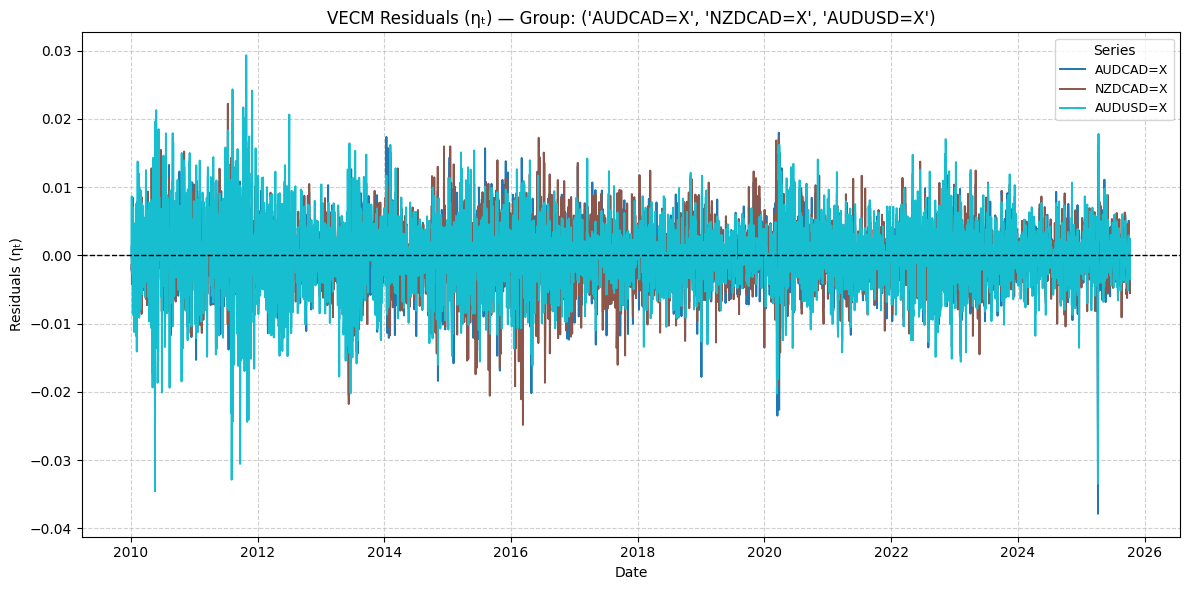


✅ Displayed residuals for group: ('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X')


In [ ]:
#function calling
plot_vecm_residuals_interactive()

####VECM α and β matrices (study later)

#Stepping into GARCH with residuals for each pairs

In [ ]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 8.8 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
import pandas as pd

# Dictionaries to store results
garch_models = {}       # Store fitted GARCH(1,1) models
garch_volatility = {}   # Store conditional volatility series
garch_std_resid = {}    # ✅ Store standardized residuals



# Loop through each group from vecm_residuals
for group, resid_df in vecm_residuals.items():     #accessing vecm_resi
    garch_models[group] = {}
    garch_volatility[group] = pd.DataFrame(index=resid_df.index)
    garch_std_resid[group] = pd.DataFrame(index=resid_df.index)

    for col in resid_df.columns:
        # Fit GARCH(1,1) on each residual series
        am = arch_model(resid_df[col], vol='Garch', p=1, q=1, dist='normal')
        res = am.fit(disp='off')

        # Store fitted model and volatility
        garch_models[group][col] = res
        garch_volatility[group][col] = res.conditional_volatility
        garch_std_resid[group][col] = res.std_resid  # ✅ standardized residuals       ### Most IMPORTANT ###

        print(f"✅ Fitted GARCH(1,1) for {col} in group {group}")

print("\n📦 All VECM residuals have been fitted with GARCH(1,1).")


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.067e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/tmp/ipython-input-1417750878.py:20: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.085e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescal

✅ Fitted GARCH(1,1) for AUDCAD=X in group ('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X')
✅ Fitted GARCH(1,1) for NZDCAD=X in group ('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X')
✅ Fitted GARCH(1,1) for AUDUSD=X in group ('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X')
✅ Fitted GARCH(1,1) for AUDNZD=X in group ('AUDNZD=X', 'GBPNZD=X', 'EURNZD=X')
✅ Fitted GARCH(1,1) for GBPNZD=X in group ('AUDNZD=X', 'GBPNZD=X', 'EURNZD=X')
✅ Fitted GARCH(1,1) for EURNZD=X in group ('AUDNZD=X', 'GBPNZD=X', 'EURNZD=X')
✅ Fitted GARCH(1,1) for AUDUSD=X in group ('AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X')
✅ Fitted GARCH(1,1) for NZDUSD=X in group ('AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X')
✅ Fitted GARCH(1,1) for AUDJPY=X in group ('AUDUSD=X', 'NZDUSD=X', 'AUDJPY=X')
✅ Fitted GARCH(1,1) for CADJPY=X in group ('CADJPY=X', 'AUDJPY=X', 'USDJPY=X')
✅ Fitted GARCH(1,1) for AUDJPY=X in group ('CADJPY=X', 'AUDJPY=X', 'USDJPY=X')
✅ Fitted GARCH(1,1) for USDJPY=X in group ('CADJPY=X', 'AUDJPY=X', 'USDJPY=X')
✅ Fitted GARCH(1,1) for CHFJPY=X in group ('CHFJPY=X

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.625e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.755e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

✅ Fitted GARCH(1,1) for EURGBP=X in group ('EURGBP=X', 'EURCAD=X', 'EURUSD=X')
✅ Fitted GARCH(1,1) for EURCAD=X in group ('EURGBP=X', 'EURCAD=X', 'EURUSD=X')
✅ Fitted GARCH(1,1) for EURUSD=X in group ('EURGBP=X', 'EURCAD=X', 'EURUSD=X')
✅ Fitted GARCH(1,1) for EURJPY=X in group ('EURJPY=X', 'GBPJPY=X', 'CHFJPY=X')
✅ Fitted GARCH(1,1) for GBPJPY=X in group ('EURJPY=X', 'GBPJPY=X', 'CHFJPY=X')
✅ Fitted GARCH(1,1) for CHFJPY=X in group ('EURJPY=X', 'GBPJPY=X', 'CHFJPY=X')
✅ Fitted GARCH(1,1) for EURNZD=X in group ('EURNZD=X', 'EURAUD=X', 'GBPNZD=X')
✅ Fitted GARCH(1,1) for EURAUD=X in group ('EURNZD=X', 'EURAUD=X', 'GBPNZD=X')
✅ Fitted GARCH(1,1) for GBPNZD=X in group ('EURNZD=X', 'EURAUD=X', 'GBPNZD=X')
✅ Fitted GARCH(1,1) for EURUSD=X in group ('EURUSD=X', 'GBPUSD=X', 'EURCAD=X')


/tmp/ipython-input-1417750878.py:20: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.755e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.626e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescal

✅ Fitted GARCH(1,1) for GBPUSD=X in group ('EURUSD=X', 'GBPUSD=X', 'EURCAD=X')
✅ Fitted GARCH(1,1) for EURCAD=X in group ('EURUSD=X', 'GBPUSD=X', 'EURCAD=X')
✅ Fitted GARCH(1,1) for GBPAUD=X in group ('GBPAUD=X', 'GBPNZD=X', 'EURAUD=X')
✅ Fitted GARCH(1,1) for GBPNZD=X in group ('GBPAUD=X', 'GBPNZD=X', 'EURAUD=X')
✅ Fitted GARCH(1,1) for EURAUD=X in group ('GBPAUD=X', 'GBPNZD=X', 'EURAUD=X')
✅ Fitted GARCH(1,1) for GBPCAD=X in group ('GBPCAD=X', 'GBPUSD=X', 'EURCAD=X')
✅ Fitted GARCH(1,1) for GBPUSD=X in group ('GBPCAD=X', 'GBPUSD=X', 'EURCAD=X')


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001478. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

✅ Fitted GARCH(1,1) for EURCAD=X in group ('GBPCAD=X', 'GBPUSD=X', 'EURCAD=X')
✅ Fitted GARCH(1,1) for GBPNZD=X in group ('GBPNZD=X', 'GBPAUD=X', 'EURNZD=X')
✅ Fitted GARCH(1,1) for GBPAUD=X in group ('GBPNZD=X', 'GBPAUD=X', 'EURNZD=X')
✅ Fitted GARCH(1,1) for EURNZD=X in group ('GBPNZD=X', 'GBPAUD=X', 'EURNZD=X')
✅ Fitted GARCH(1,1) for GBPUSD=X in group ('GBPUSD=X', 'GBPCAD=X', 'EURUSD=X')
✅ Fitted GARCH(1,1) for GBPCAD=X in group ('GBPUSD=X', 'GBPCAD=X', 'EURUSD=X')
✅ Fitted GARCH(1,1) for EURUSD=X in group ('GBPUSD=X', 'GBPCAD=X', 'EURUSD=X')
✅ Fitted GARCH(1,1) for NZDCAD=X in group ('NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X')
✅ Fitted GARCH(1,1) for NZDUSD=X in group ('NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X')
✅ Fitted GARCH(1,1) for AUDCAD=X in group ('NZDCAD=X', 'NZDUSD=X', 'AUDCAD=X')
✅ Fitted GARCH(1,1) for NZDUSD=X in group ('NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X')


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001478. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

✅ Fitted GARCH(1,1) for AUDUSD=X in group ('NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X')
✅ Fitted GARCH(1,1) for NZDCAD=X in group ('NZDUSD=X', 'AUDUSD=X', 'NZDCAD=X')
✅ Fitted GARCH(1,1) for USDCAD=X in group ('USDCAD=X', 'EURCAD=X', 'GBPCAD=X')
✅ Fitted GARCH(1,1) for EURCAD=X in group ('USDCAD=X', 'EURCAD=X', 'GBPCAD=X')
✅ Fitted GARCH(1,1) for GBPCAD=X in group ('USDCAD=X', 'EURCAD=X', 'GBPCAD=X')
✅ Fitted GARCH(1,1) for USDJPY=X in group ('USDJPY=X', 'CADJPY=X', 'GBPJPY=X')
✅ Fitted GARCH(1,1) for CADJPY=X in group ('USDJPY=X', 'CADJPY=X', 'GBPJPY=X')
✅ Fitted GARCH(1,1) for GBPJPY=X in group ('USDJPY=X', 'CADJPY=X', 'GBPJPY=X')

📦 All VECM residuals have been fitted with GARCH(1,1).


/tmp/ipython-input-1417750878.py:20: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.085e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.333e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescal

####As expected 19 X 3 = 57 garch(1,1) models

In [ ]:
print(garch_std_resid)

{('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X'):               AUDCAD=X  NZDCAD=X  AUDUSD=X
Date                                      
2010-01-05 -138.713379  0.485702 -0.039946
2010-01-06   -4.438324  0.683942  1.363357
2010-01-07   -3.220626 -0.081019 -0.408424
2010-01-08   -2.656024  1.246049  1.130643
2010-01-11   -2.321136  3.264425  0.767914
...                ...       ...       ...
2025-10-03   -1.185729  1.048825 -0.387988
2025-10-06   -1.185242  1.013031 -0.126104
2025-10-07   -1.179476  1.062357  0.658518
2025-10-08   -1.195202 -0.323825 -0.973848
2025-10-09   -1.182993  0.356573 -0.009786

[4110 rows x 3 columns], ('AUDNZD=X', 'GBPNZD=X', 'EURNZD=X'):             AUDNZD=X  GBPNZD=X  EURNZD=X
Date                                    
2010-01-05  0.027238 -1.031396 -0.468472
2010-01-06  0.861332 -0.606575 -0.573974
2010-01-07  1.228863  0.297573  0.432417
2010-01-08  0.516041 -0.066494  0.472494
2010-01-11 -0.415174 -0.020723  0.008743
...              ...       ...       ...
2025-10-03

In [ ]:
import pandas as pd

rows = []
for group, col_models in garch_models.items():
    for col in col_models:
        rows.append({"Series": col, "Group": group })

df_garch_summary = pd.DataFrame(rows)
print(df_garch_summary)
print(f"\n✅ Total GARCH(1,1) models fitted: {len(df_garch_summary)}")


      Series                           Group
0   AUDCAD=X  (AUDCAD=X, NZDCAD=X, AUDUSD=X)
1   NZDCAD=X  (AUDCAD=X, NZDCAD=X, AUDUSD=X)
2   AUDUSD=X  (AUDCAD=X, NZDCAD=X, AUDUSD=X)
3   AUDNZD=X  (AUDNZD=X, GBPNZD=X, EURNZD=X)
4   GBPNZD=X  (AUDNZD=X, GBPNZD=X, EURNZD=X)
5   EURNZD=X  (AUDNZD=X, GBPNZD=X, EURNZD=X)
6   AUDUSD=X  (AUDUSD=X, NZDUSD=X, AUDJPY=X)
7   NZDUSD=X  (AUDUSD=X, NZDUSD=X, AUDJPY=X)
8   AUDJPY=X  (AUDUSD=X, NZDUSD=X, AUDJPY=X)
9   CADJPY=X  (CADJPY=X, AUDJPY=X, USDJPY=X)
10  AUDJPY=X  (CADJPY=X, AUDJPY=X, USDJPY=X)
11  USDJPY=X  (CADJPY=X, AUDJPY=X, USDJPY=X)
12  CHFJPY=X  (CHFJPY=X, EURJPY=X, GBPJPY=X)
13  EURJPY=X  (CHFJPY=X, EURJPY=X, GBPJPY=X)
14  GBPJPY=X  (CHFJPY=X, EURJPY=X, GBPJPY=X)
15  EURAUD=X  (EURAUD=X, EURNZD=X, GBPAUD=X)
16  EURNZD=X  (EURAUD=X, EURNZD=X, GBPAUD=X)
17  GBPAUD=X  (EURAUD=X, EURNZD=X, GBPAUD=X)
18  EURCHF=X  (EURCHF=X, GBPCHF=X, AUDCHF=X)
19  GBPCHF=X  (EURCHF=X, GBPCHF=X, AUDCHF=X)
20  AUDCHF=X  (EURCHF=X, GBPCHF=X, AUDCHF=X)
21  EURGBP

In [ ]:
rows = []
for group, col_models in garch_models.items():
    for col, res in col_models.items():
        params = res.params
        rows.append({
            "Group": group,
            "Series": col,
            "Omega": params.get("omega", None),
            "Alpha(1)": params.get("alpha[1]", None),
            "Beta(1)": params.get("beta[1]", None),
            "LogLik": res.loglikelihood,
            "AIC": res.aic,
            "BIC": res.bic
        })

df_garch_summary = pd.DataFrame(rows)
print(df_garch_summary)
print(f"\n✅ Total GARCH(1,1) models fitted: {len(df_garch_summary)}")


                             Group    Series         Omega  Alpha(1)  \
0   (AUDCAD=X, NZDCAD=X, AUDUSD=X)  AUDCAD=X  4.134802e-07  0.050000   
1   (AUDCAD=X, NZDCAD=X, AUDUSD=X)  NZDCAD=X  4.191646e-07  0.050009   
2   (AUDCAD=X, NZDCAD=X, AUDUSD=X)  AUDUSD=X  5.791632e-07  0.050000   
3   (AUDNZD=X, GBPNZD=X, EURNZD=X)  AUDNZD=X  3.894103e-07  0.050000   
4   (AUDNZD=X, GBPNZD=X, EURNZD=X)  GBPNZD=X  2.954844e-06  0.050000   
5   (AUDNZD=X, GBPNZD=X, EURNZD=X)  EURNZD=X  1.950391e-06  0.050000   
6   (AUDUSD=X, NZDUSD=X, AUDJPY=X)  AUDUSD=X  5.770789e-07  0.050000   
7   (AUDUSD=X, NZDUSD=X, AUDJPY=X)  NZDUSD=X  4.735069e-07  0.050000   
8   (AUDUSD=X, NZDUSD=X, AUDJPY=X)  AUDJPY=X  1.473658e-02  0.104869   
9   (CADJPY=X, AUDJPY=X, USDJPY=X)  CADJPY=X  7.804238e-03  0.077457   
10  (CADJPY=X, AUDJPY=X, USDJPY=X)  AUDJPY=X  1.473878e-02  0.104519   
11  (CADJPY=X, AUDJPY=X, USDJPY=X)  USDJPY=X  3.336365e-03  0.058935   
12  (CHFJPY=X, EURJPY=X, GBPJPY=X)  CHFJPY=X  1.414679e-02  0.14

Enter a series name (e.g. AUDCAD=X): AUDCAD=X


/tmp/ipython-input-2565098497.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(cols))  # Get distinct colors


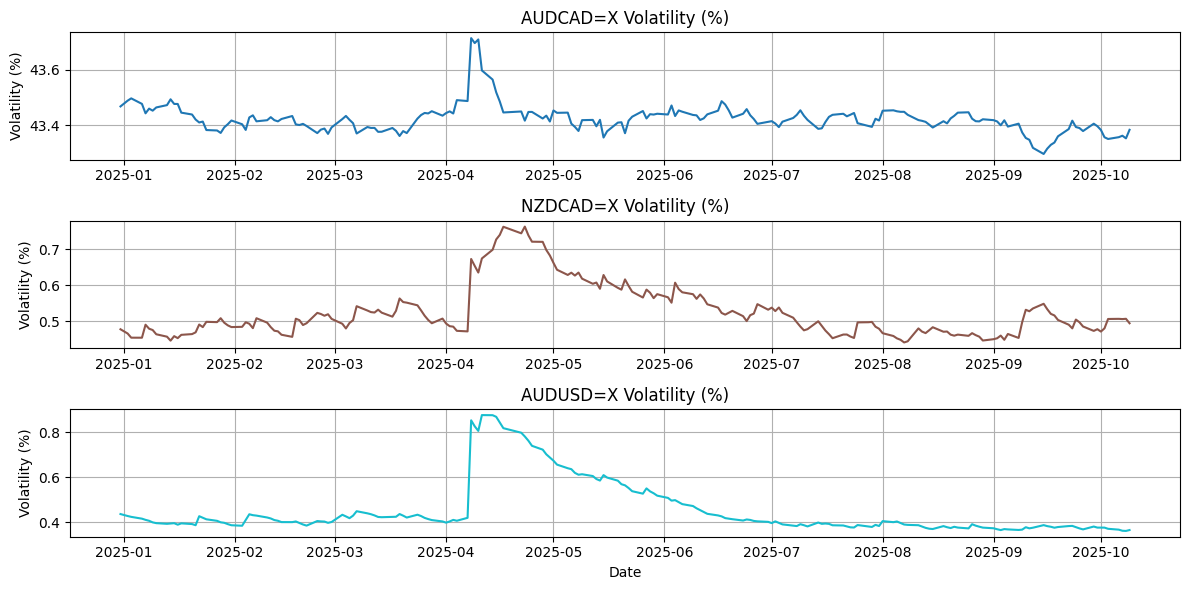

In [ ]:
import matplotlib.pyplot as plt

def plot_group_volatility_percent(series_name, last_n=200):
    """
    Plots conditional volatility for the full group of a given series in percentage scale.

    :param series_name: str, e.g., 'AUDCAD=X'
    :param last_n: int, number of most recent observations to plot
    """
    # Find the group containing the series
    target_group = None
    for group in garch_volatility:
        if series_name in garch_volatility[group].columns:
            target_group = group
            break

    if not target_group:
        print(f"❌ Series '{series_name}' not found in any group.")
        return

    # Plot volatility for all series in the group (scaled to %)
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    plt.figure(figsize=(12, 6))

    cols = garch_volatility[target_group].columns
    colors = cm.get_cmap('tab10', len(cols))  # Get distinct colors

    for i, col in enumerate(cols):
        plt.subplot(len(cols), 1, i + 1)
        vol_percent = garch_volatility[target_group][col].tail(last_n) * 100
        plt.plot(vol_percent, label=col, color=colors(i))
        plt.title(f"{col} Volatility (%)")
        plt.ylabel("Volatility (%)")
        plt.grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()




# Example usage:
series_input = input("Enter a series name (e.g. AUDCAD=X): ").strip()
plot_group_volatility_percent(series_input, last_n=200)


Enter a series name (e.g., AUDCAD=X): AUDCAD=X


/tmp/ipython-input-717217835.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(cols))


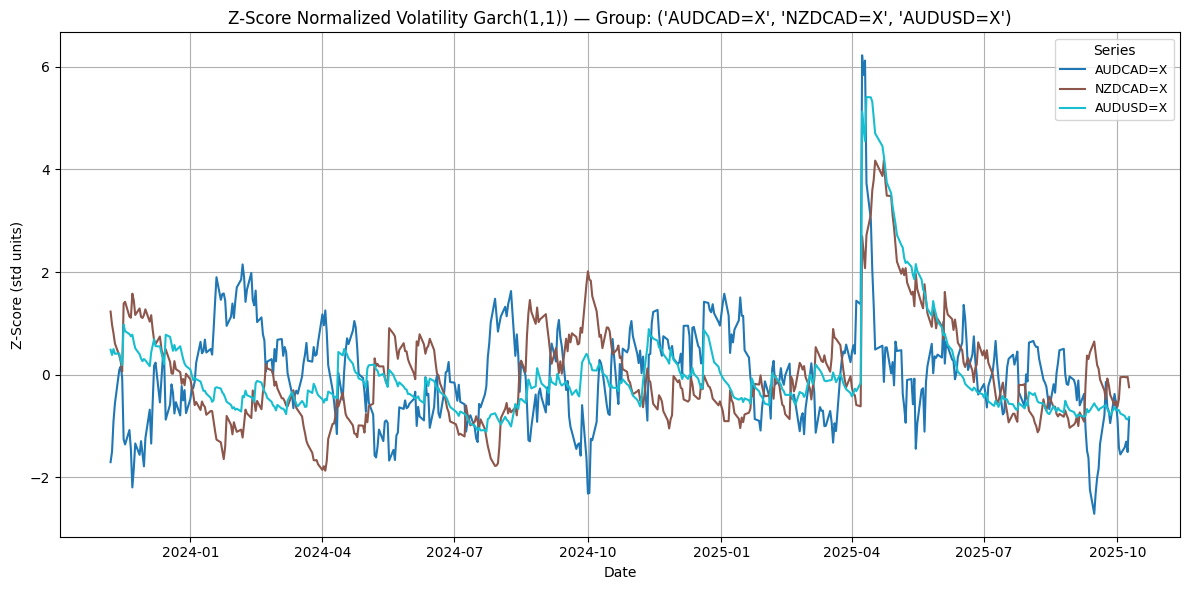

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

def plot_group_volatility_percent(series_name, last_n=200, zscore=True):
    """
    Plots conditional volatility (in %) for all series in the same group as the given series,
    aligned by date for accurate comparison.

    If zscore=True, applies z-score normalization so patterns overlap visually
    (each series has mean 0 and std 1).
    """
    # --- Find group that contains the series
    target_group = None
    for group in garch_volatility:
        if series_name in garch_volatility[group].columns:
            target_group = group
            break

    if not target_group:
        print(f"❌ Series '{series_name}' not found in any group.")
        return

    # --- Prepare data
    group_data = garch_volatility[target_group].copy()
    group_data = group_data.dropna(how='any').tail(last_n)
    vol_percent = group_data * 100

    # --- Z-score normalization
    if zscore:
        vol_percent = (vol_percent - vol_percent.mean()) / vol_percent.std()

    # --- Plot
    plt.figure(figsize=(12, 6))
    cols = vol_percent.columns
    colors = cm.get_cmap('tab10', len(cols))

    for i, col in enumerate(cols):
        plt.plot(vol_percent.index, vol_percent[col], label=col, color=colors(i))

    title = f"Z-Score Normalized Volatility Garch(1,1)) — Group: {target_group}" if zscore \
            else f"Aligned Volatility Comparison (%) — Group: {target_group}"
    ylabel = "Z-Score (std units)" if zscore else "Volatility (%)"

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend(title="Series", loc="upper right", fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
series_input = input("Enter a series name (e.g., AUDCAD=X): ").strip()
plot_group_volatility_percent(series_input, last_n=500)

#----------------------------XXXXXX---------------------------

#DCC (Dynamic Conditional Correlation)

In [ ]:
!pip install -U arch



In [ ]:
!pip install -U arch


####Standardized residuals

In [ ]:
#Collected from garch
print(garch_std_resid)

{('AUDCAD=X', 'NZDCAD=X', 'AUDUSD=X'):               AUDCAD=X  NZDCAD=X  AUDUSD=X
Date                                      
2010-01-05 -138.713379  0.485702 -0.039946
2010-01-06   -4.438324  0.683942  1.363357
2010-01-07   -3.220626 -0.081019 -0.408424
2010-01-08   -2.656024  1.246049  1.130643
2010-01-11   -2.321136  3.264425  0.767914
...                ...       ...       ...
2025-10-03   -1.185729  1.048825 -0.387988
2025-10-06   -1.185242  1.013031 -0.126104
2025-10-07   -1.179476  1.062357  0.658518
2025-10-08   -1.195202 -0.323825 -0.973848
2025-10-09   -1.182993  0.356573 -0.009786

[4110 rows x 3 columns], ('AUDNZD=X', 'GBPNZD=X', 'EURNZD=X'):             AUDNZD=X  GBPNZD=X  EURNZD=X
Date                                    
2010-01-05  0.027238 -1.031396 -0.468472
2010-01-06  0.861332 -0.606575 -0.573974
2010-01-07  1.228863  0.297573  0.432417
2010-01-08  0.516041 -0.066494  0.472494
2010-01-11 -0.415174 -0.020723  0.008743
...              ...       ...       ...
2025-10-03

####Ready standardize residuals(from garch[1,1]) for DCC

#------------------------------------XXXXXXXXXXXXX----------------------------

In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

#Not accessing to mgarch

In [ ]:
!ls /content/quant-trading/mgarch


ls: cannot access '/content/quant-trading/mgarch': No such file or directory


#Engle (2002) DCC(1,1)    Base Version DCC


In [ ]:
import numpy as np

class DCC_local:
    def __init__(self, a=0.01, b=0.98):
        self.a = a
        self.b = b
        self.Rt = None

    def fit(self, eps):
        T, N = eps.shape
        Qbar = np.cov(eps.T)
        Qt = Qbar.copy()
        Rt = np.zeros((T, N, N))
        for t in range(T):
            ut = np.outer(eps[t], eps[t])
            Qt = (1 - self.a - self.b) * Qbar + self.a * ut + self.b * Qt
            diag = np.sqrt(np.diag(Qt))
            Rt[t] = Qt / np.outer(diag, diag)
        self.Rt = Rt
        return Rt


Enter a series name (e.g. AUDCAD=X): AUDCAD=X


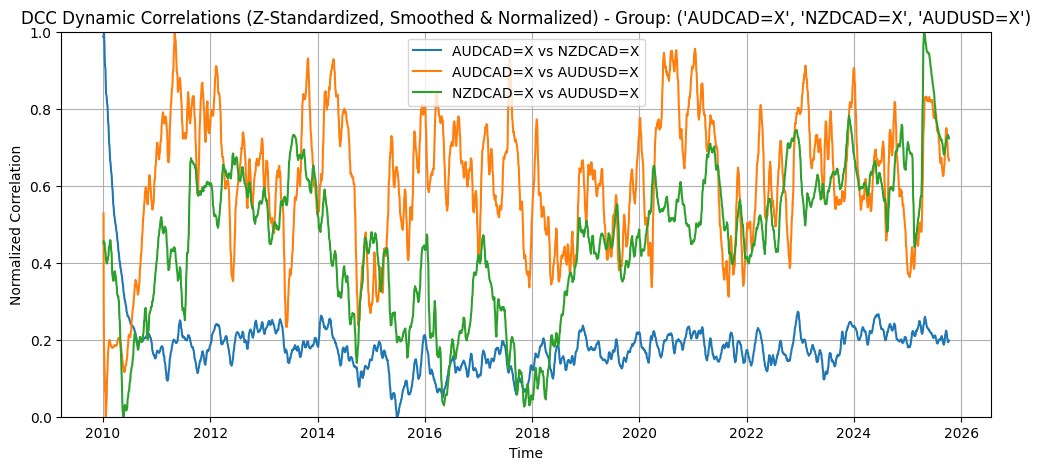

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# -------------------------------
# 2️⃣ z-standardize
# -------------------------------
def z_standardize(df):
    return (df - df.mean()) / df.std()

# -------------------------------
# 3️⃣ Function to plot DCC correlations for any pair in a group
# -------------------------------
def plot_group_dcc_by_series(series_name, garch_std_resid, smooth_window=10):
    """
    Plots all 3 pair correlations for the group containing the given series name.

    :param series_name: str, e.g., 'AUDCAD=X'
    :param garch_std_resid: dict of standardized residuals per group
    :param smooth_window: int, rolling window for smoothing correlations
    """
    # Find the group containing the series
    target_group = None
    for group in garch_std_resid:
        if series_name in garch_std_resid[group].columns:
            target_group = group
            break

    if not target_group:
        print(f"❌ Series '{series_name}' not found in any group.")
        return

    std_resid_df = garch_std_resid[target_group]
    assets = list(std_resid_df.columns)

    if len(assets) != 3:
        print(f"❌ Group '{target_group}' does not contain exactly 3 assets.")
        return

    # z-standardize residuals
    eps_df = z_standardize(std_resid_df)
    eps = eps_df.values

    # Fit DCC
    dcc_model = DCC_local()
    Rt = dcc_model.fit(eps)

    plt.figure(figsize=(12,5))

    # Plot all 3 pairs
    pairs = [(0,1), (0,2), (1,2)]
    for i,j in pairs:
        corr_line = Rt[:, i, j]
        corr_smooth = pd.Series(corr_line).rolling(window=smooth_window, min_periods=1).mean()
        corr_norm = (corr_smooth - corr_smooth.min()) / (corr_smooth.max() - corr_smooth.min())
        plt.plot(std_resid_df.index, corr_norm, label=f"{assets[i]} vs {assets[j]}")

    plt.title(f"DCC Dynamic Correlations (Z-Standardized, Smoothed & Normalized) - Group: {target_group}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Correlation")
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()

# -------------------------------
# 4️⃣ Interactive input
# -------------------------------
series_input = input("Enter a series name (e.g. AUDCAD=X): ").strip()
plot_group_dcc_by_series(series_input, garch_std_resid, smooth_window=10)


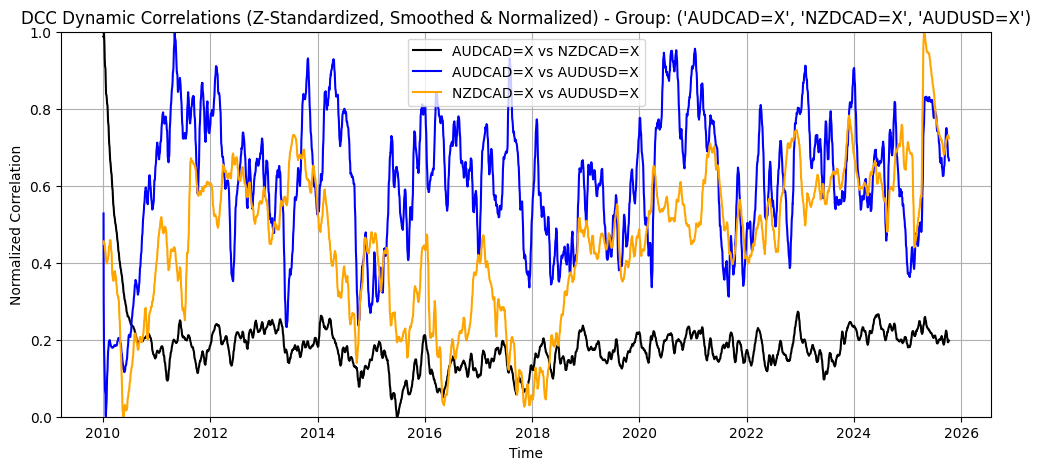

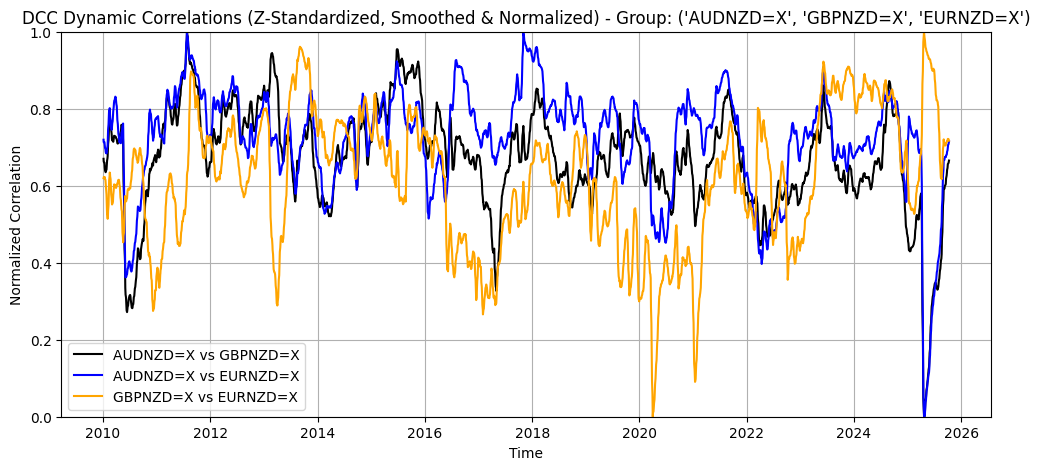

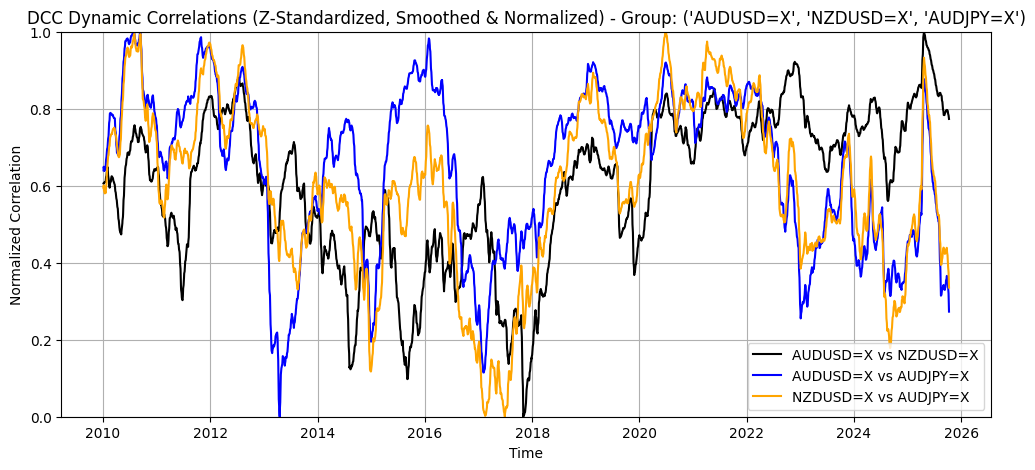

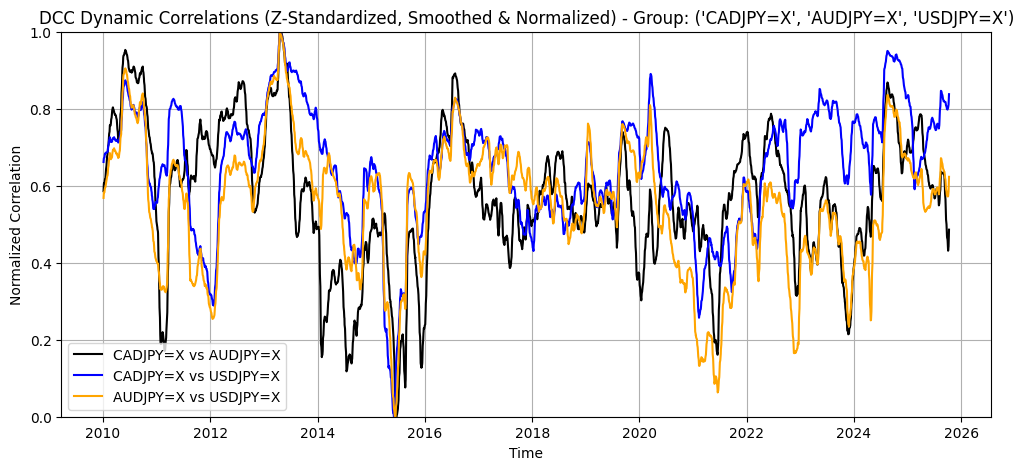

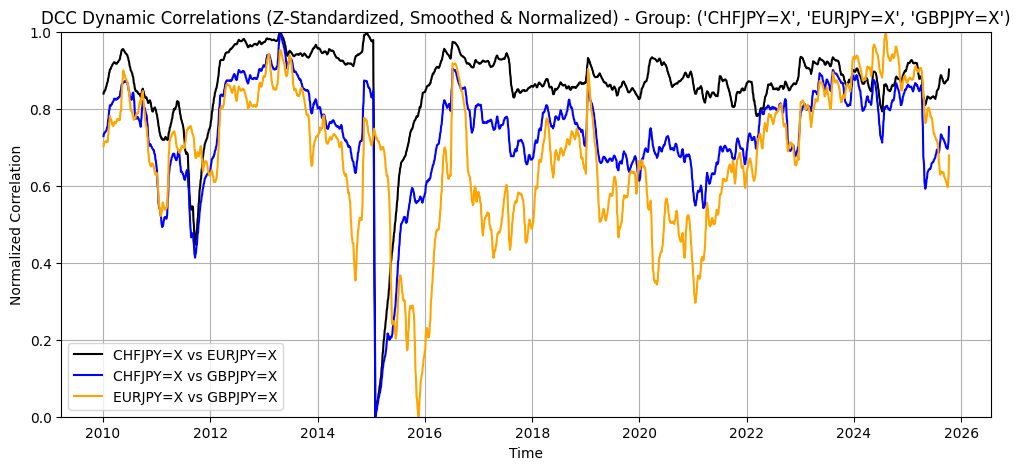

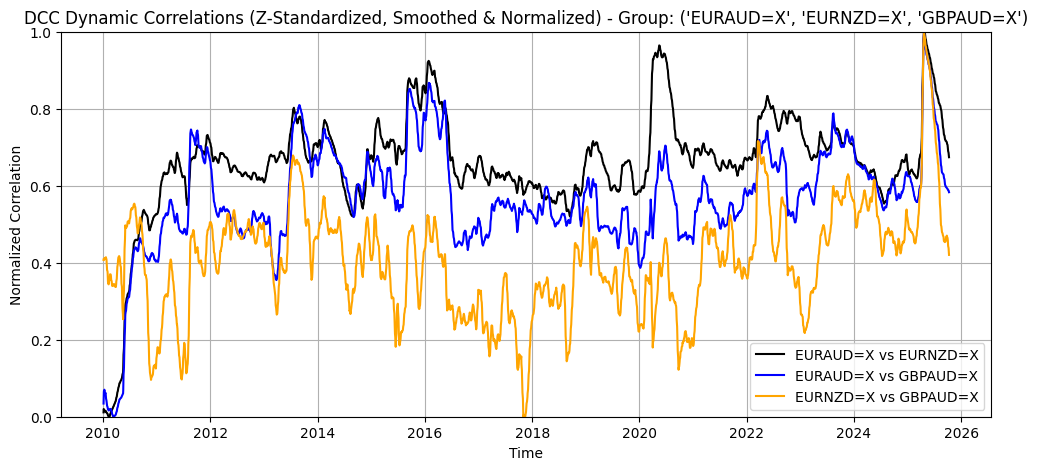

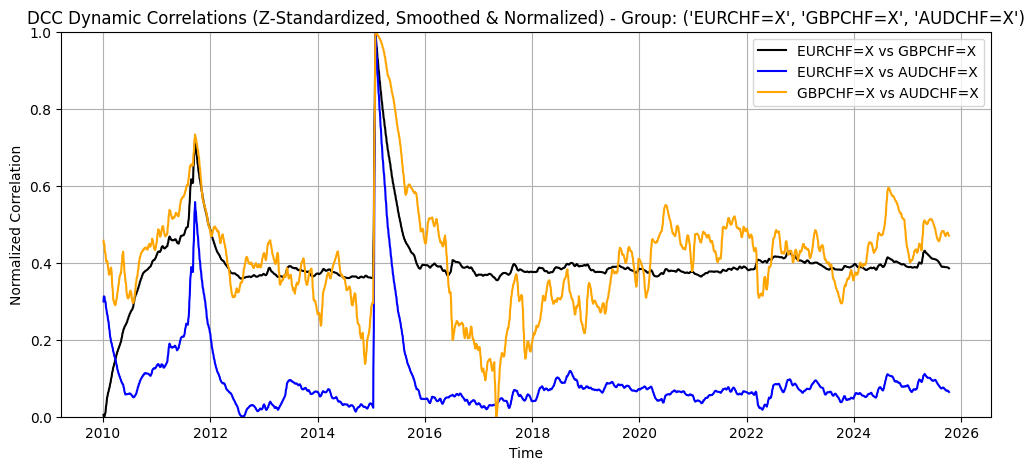

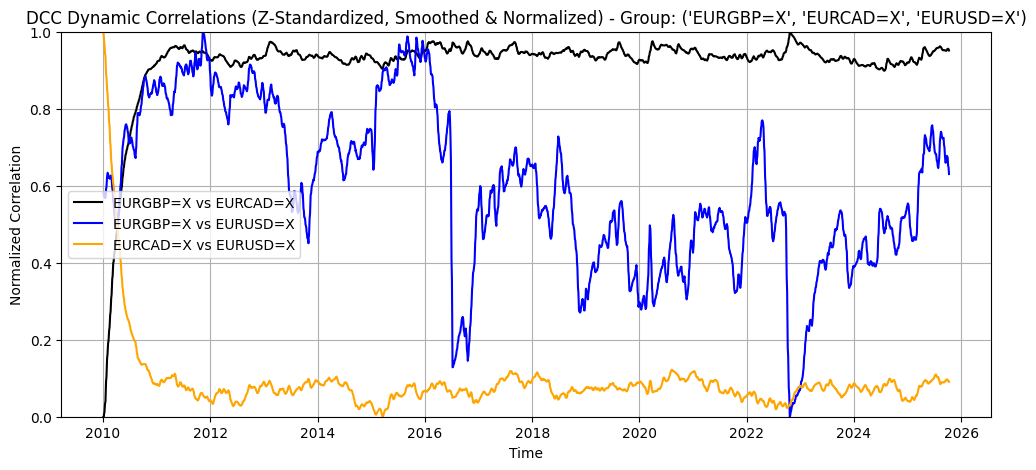

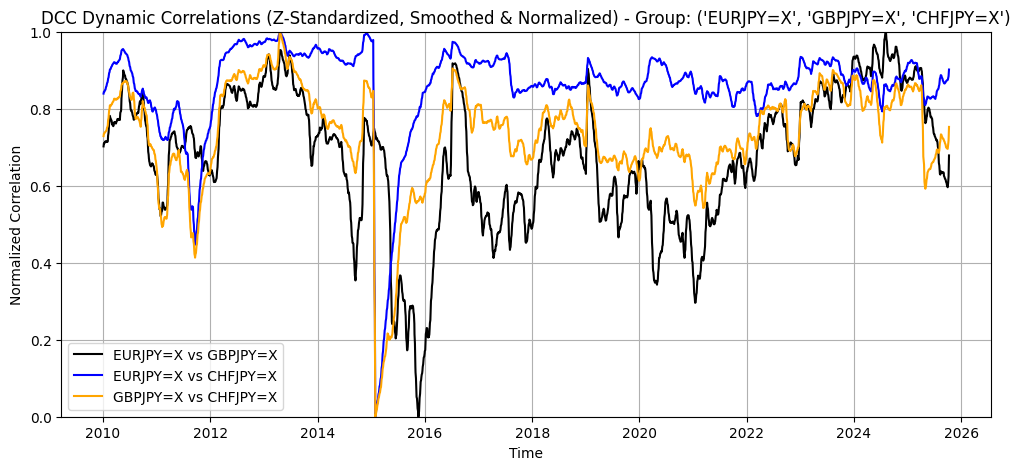

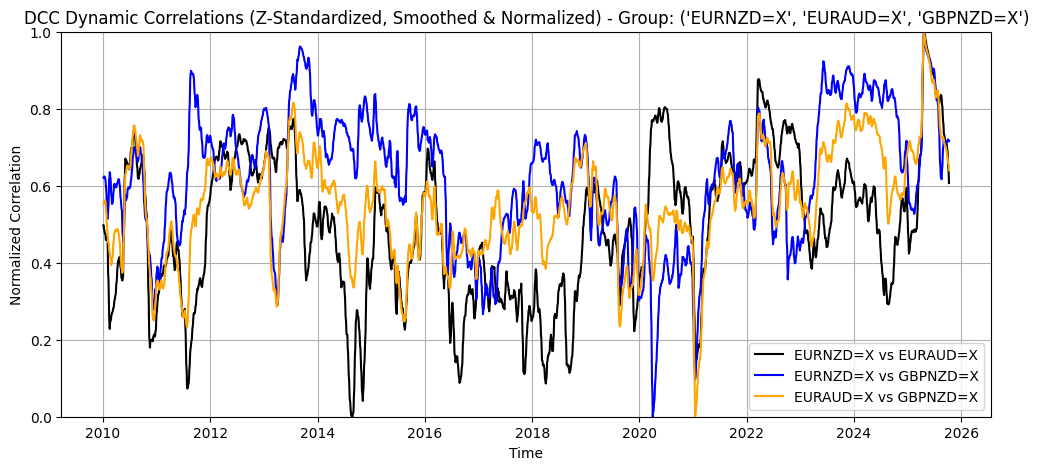

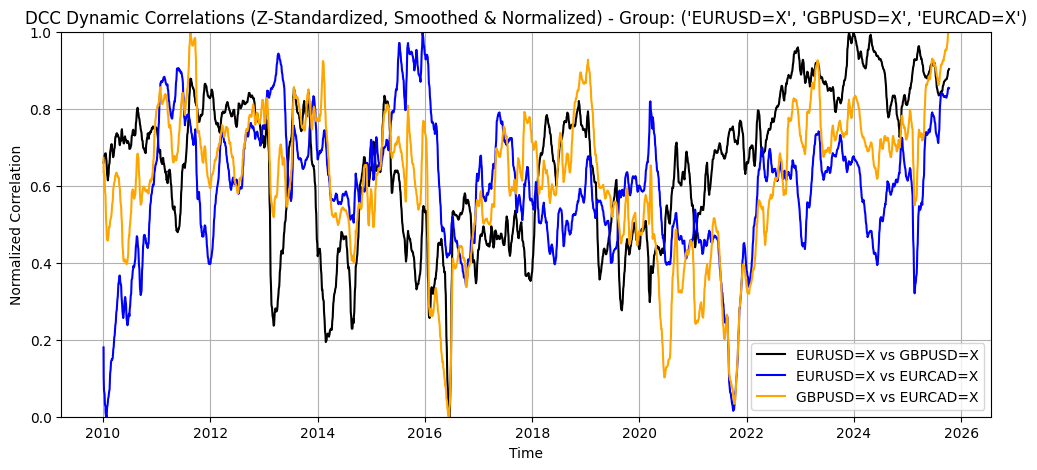

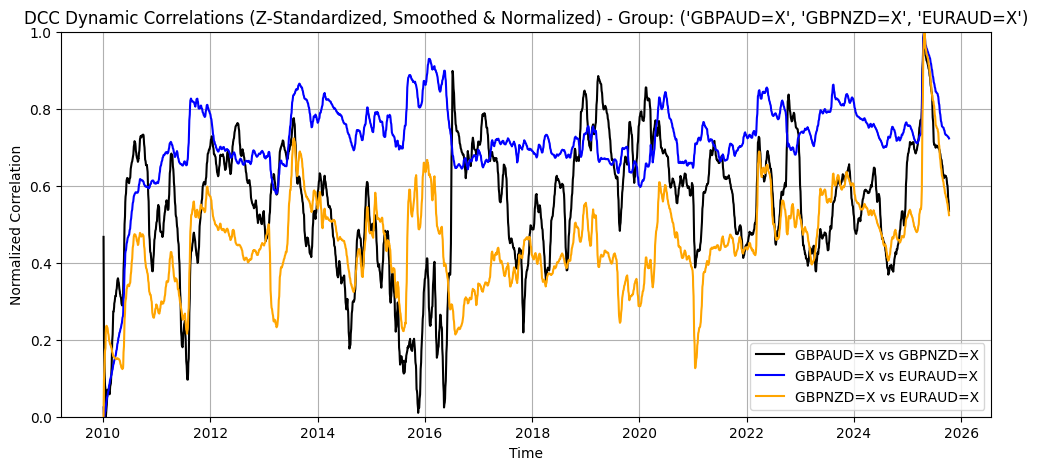

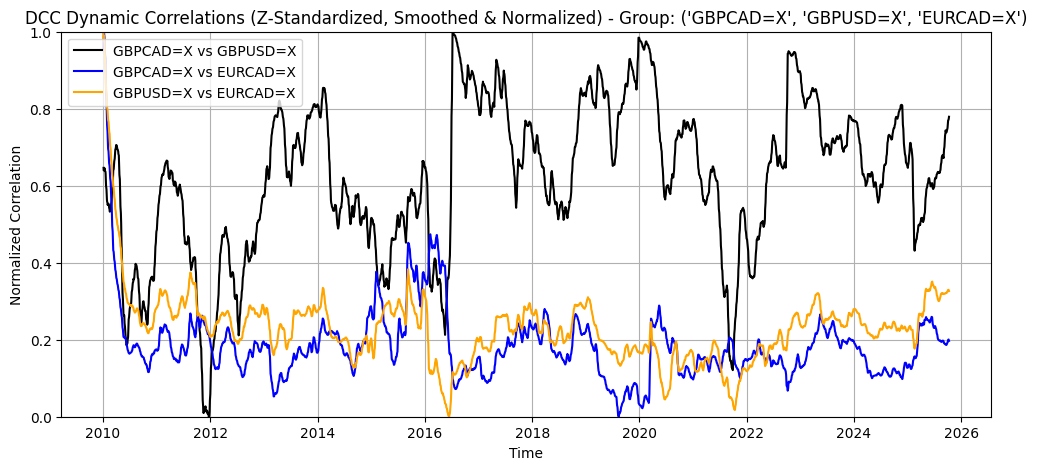

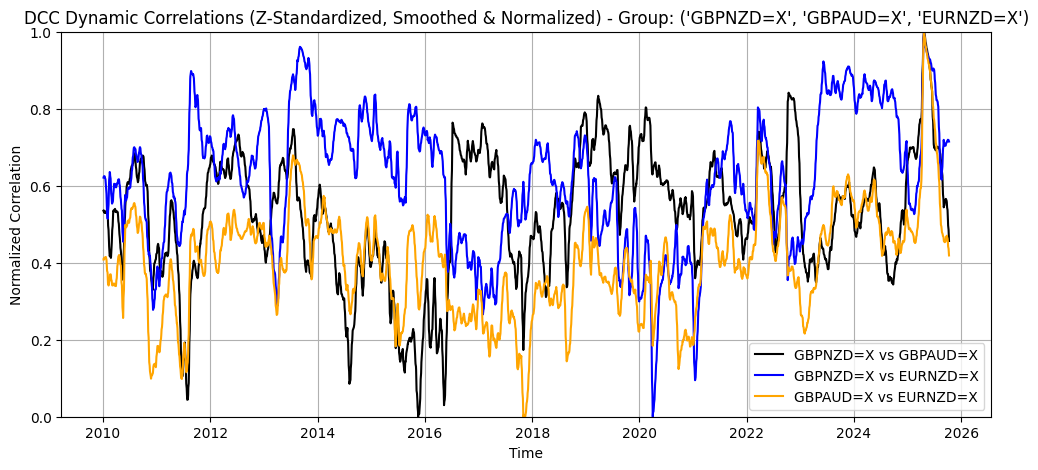

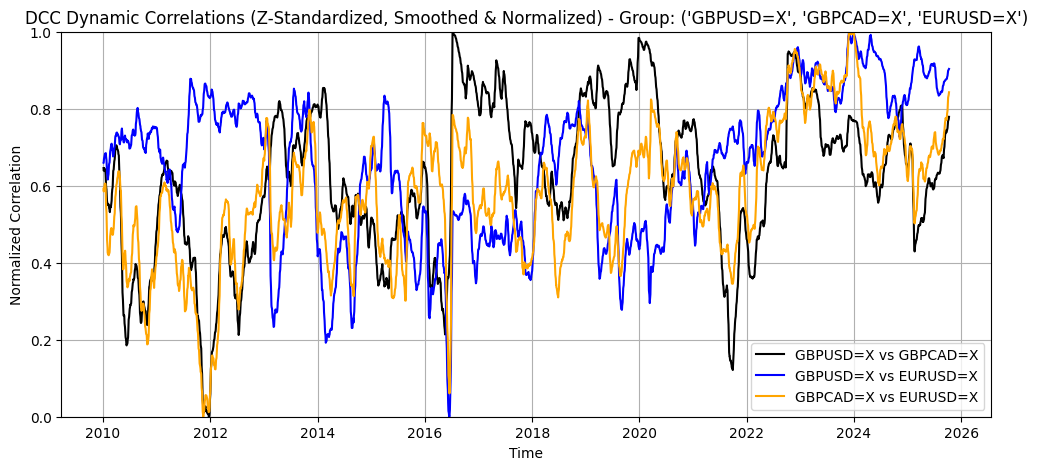

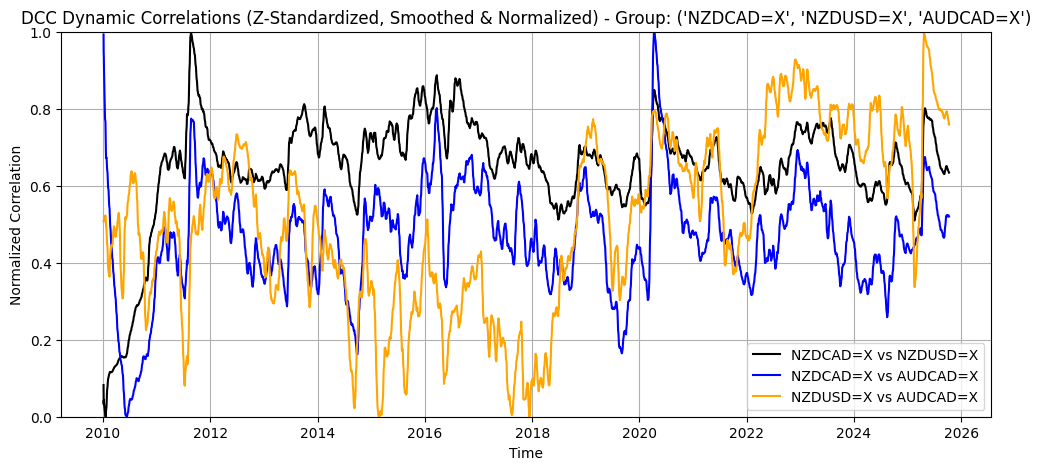

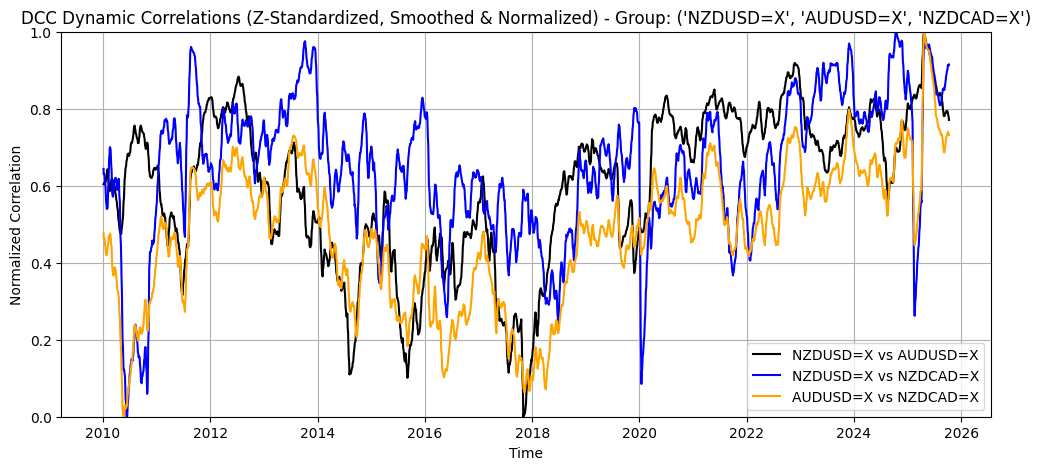

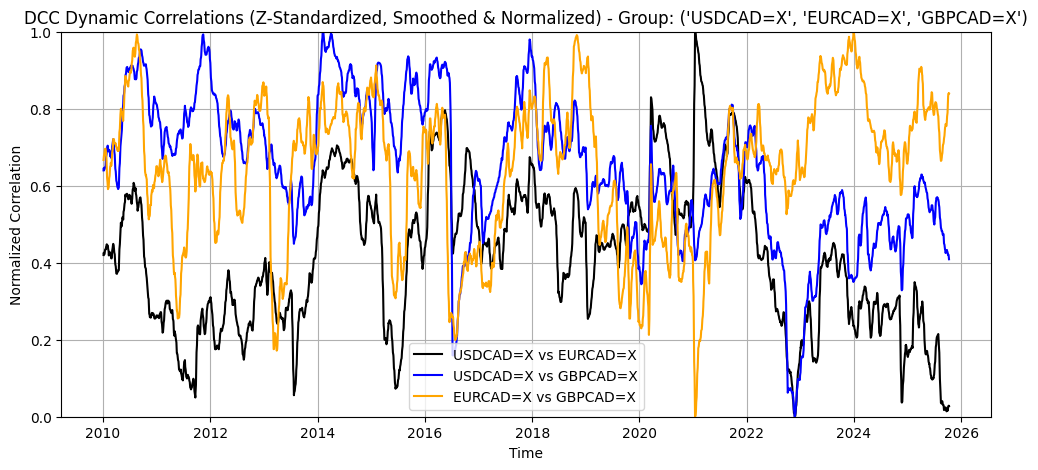

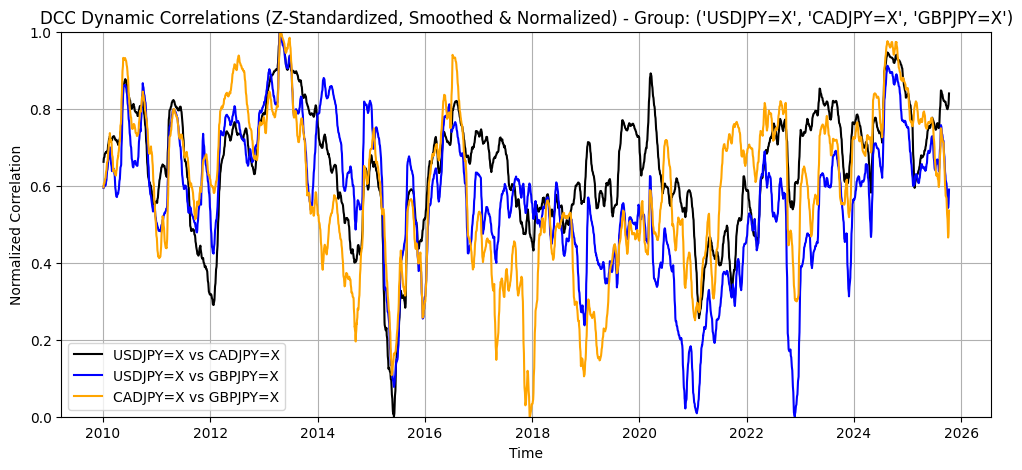

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# -------------------------------
# 2️⃣ z-standardize function
# -------------------------------
def z_standardize(df):
    return (df - df.mean()) / df.std()

# -------------------------------
# 3️⃣ Function to plot all pairwise DCC correlations per group with custom colors
# -------------------------------
def plot_group_dcc_overlapping(garch_std_resid, group_key, smooth_window=10):
    """
    garch_std_resid: dict of standardized residuals per group
    group_key: group to plot
    smooth_window: window for rolling mean smoothing
    """
    std_resid_df = garch_std_resid[group_key]

    # z-standardize residuals
    eps_df = z_standardize(std_resid_df)
    eps = eps_df.values
    asset_names = std_resid_df.columns
    N = len(asset_names)

    # Fit DCC
    dcc_model = DCC_local()
    Rt = dcc_model.fit(eps)

    plt.figure(figsize=(12,5))

    # Set colors for the three lines
    colors = ['black', 'blue', 'orange']

    # Plot all 3 pairs
    pairs = [(0,1), (0,2), (1,2)]
    for idx, (i,j) in enumerate(pairs):
        corr_line = Rt[:, i, j]

        # Smooth correlation using rolling mean
        corr_smooth = pd.Series(corr_line).rolling(window=smooth_window, min_periods=1).mean()

        # Normalize to [0,1] for overlapping pattern visualization
        corr_norm = (corr_smooth - corr_smooth.min()) / (corr_smooth.max() - corr_smooth.min())

        plt.plot(std_resid_df.index, corr_norm, label=f"{asset_names[i]} vs {asset_names[j]}", color=colors[idx])

    plt.title(f"DCC Dynamic Correlations (Z-Standardized, Smoothed & Normalized) - Group: {group_key}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Correlation")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

# -------------------------------
# 4️⃣ Example usage: loop over all groups
# -------------------------------
for group_key in garch_std_resid.keys():
    print("\n\n")
    plot_group_dcc_overlapping(garch_std_resid, group_key, smooth_window=10)



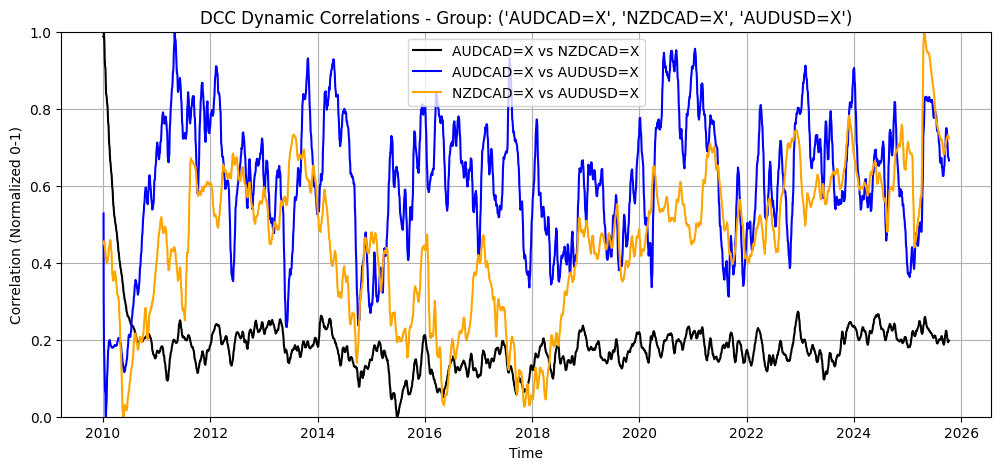

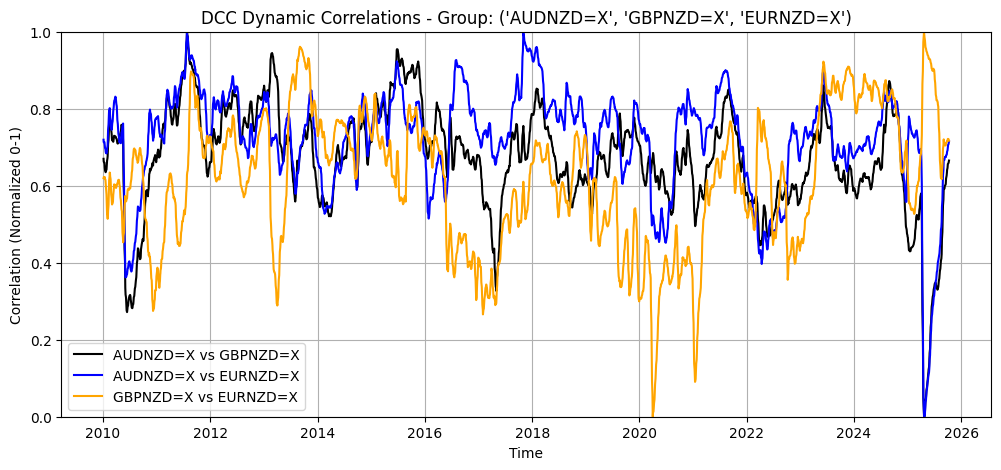

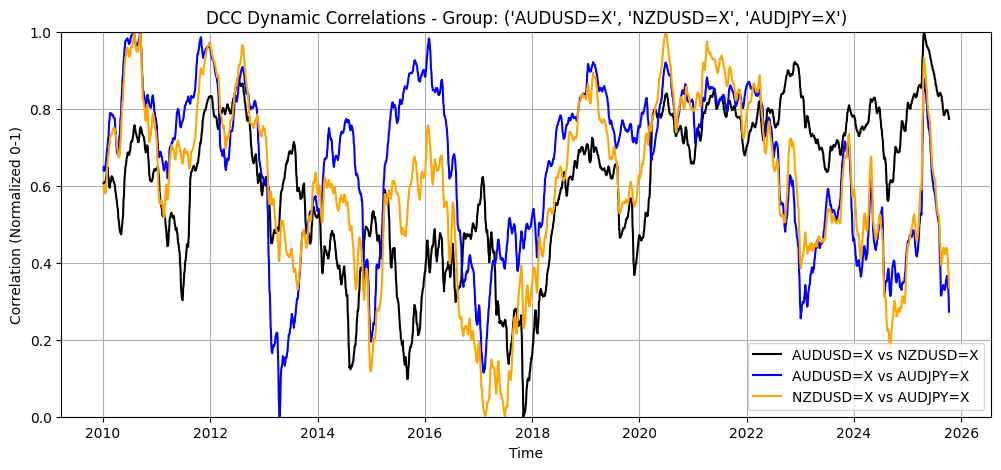

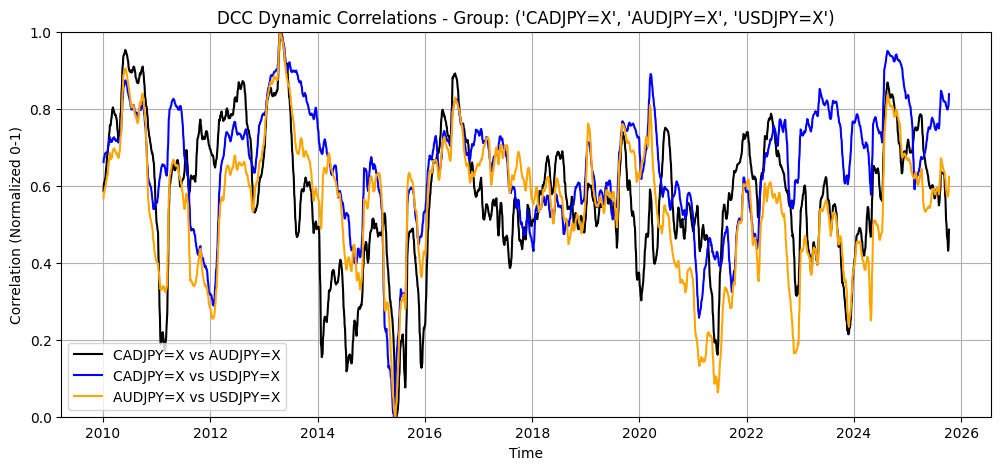

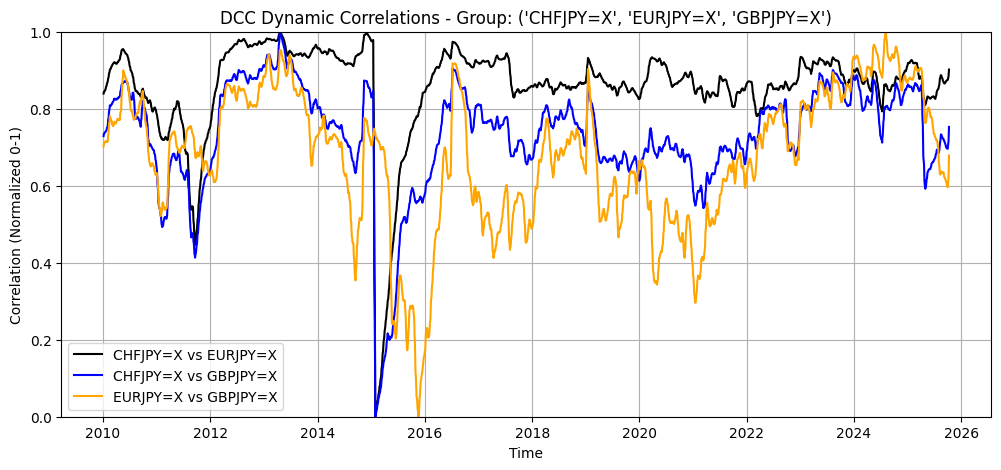

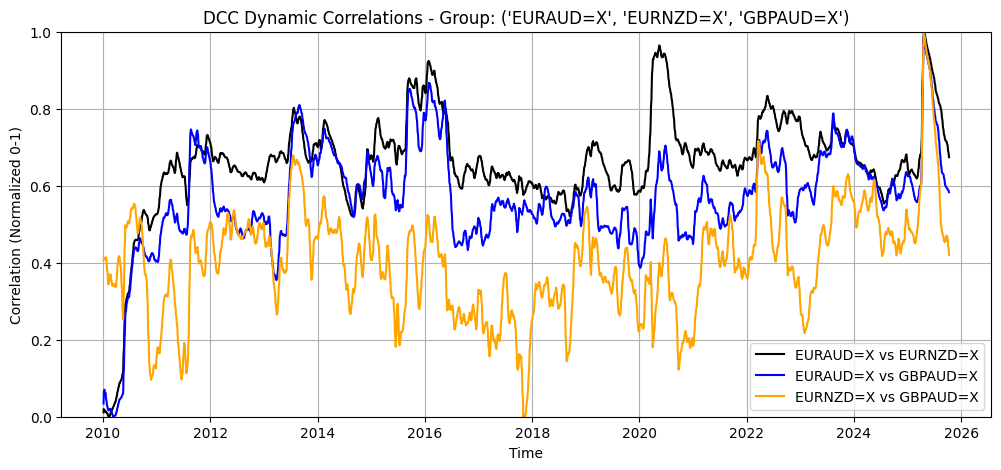

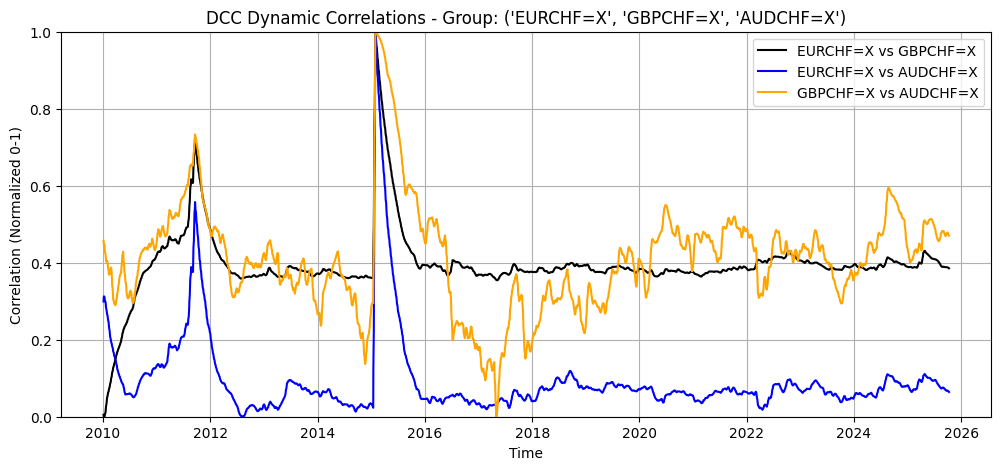

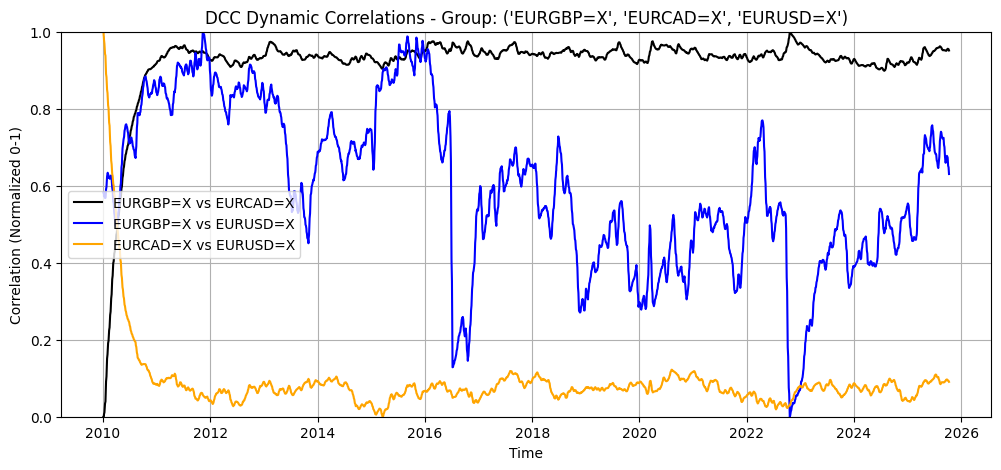

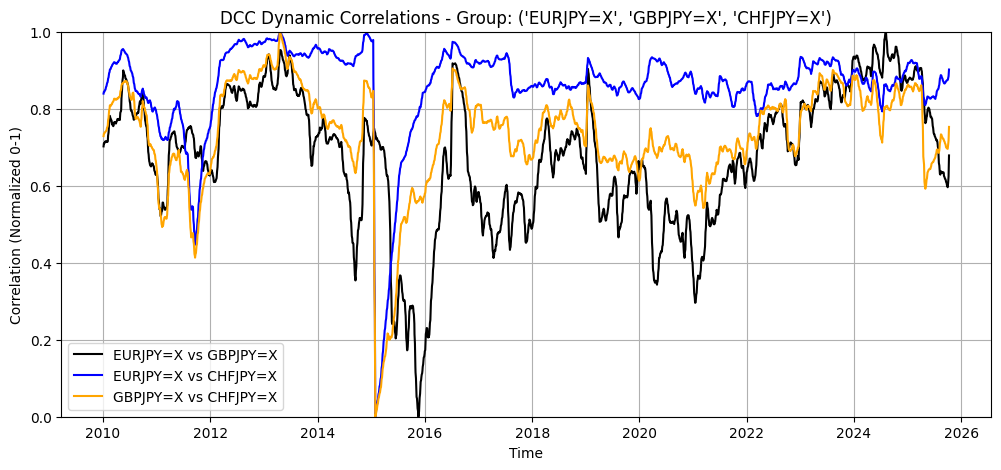

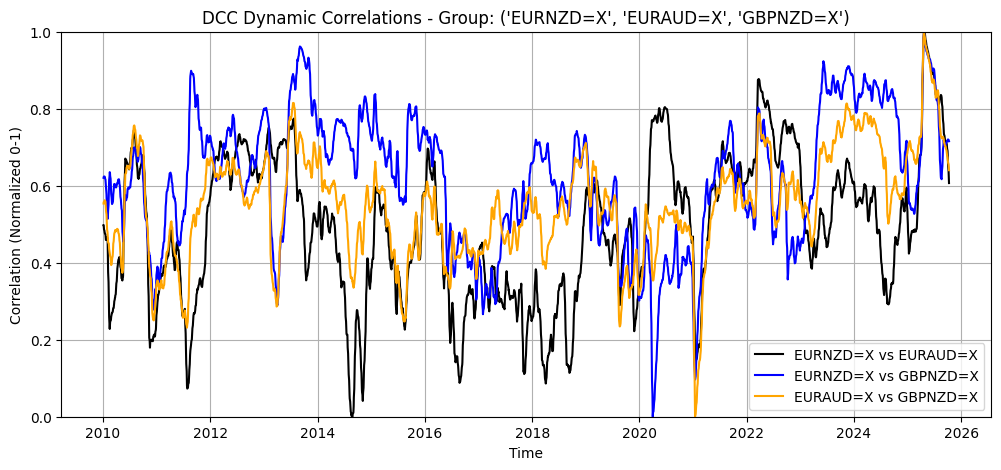

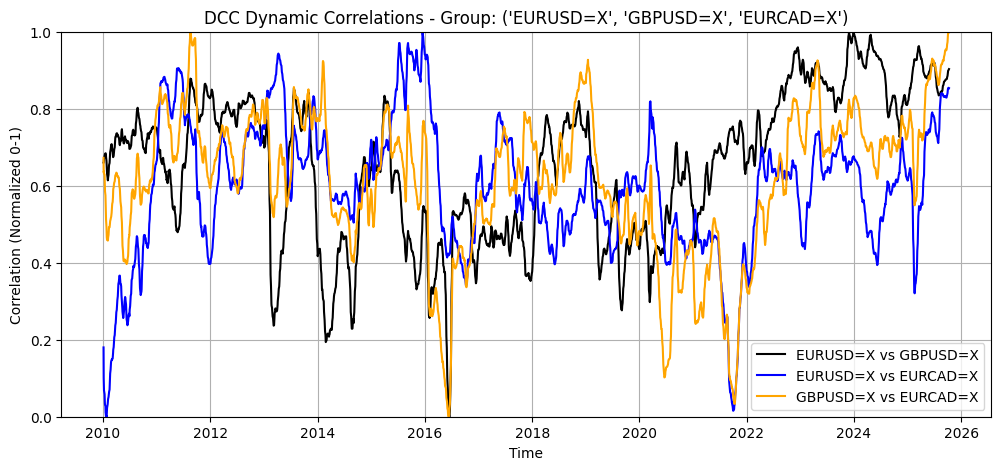

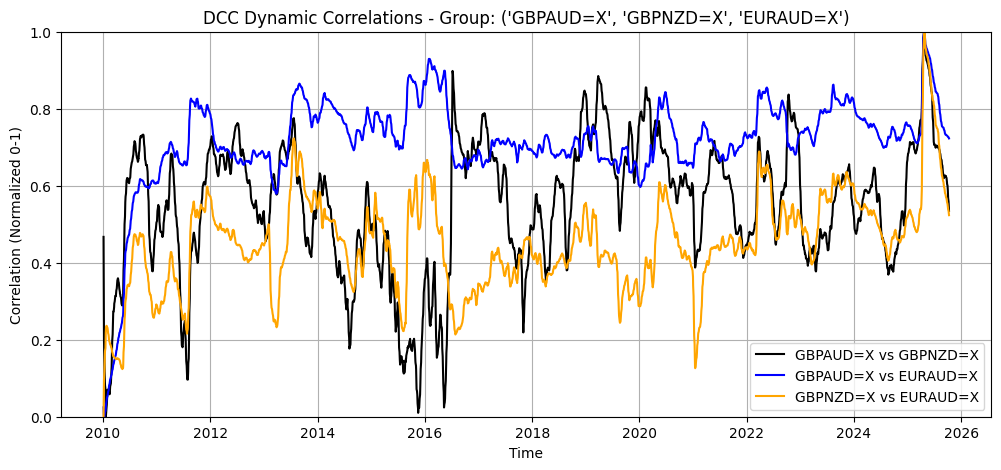

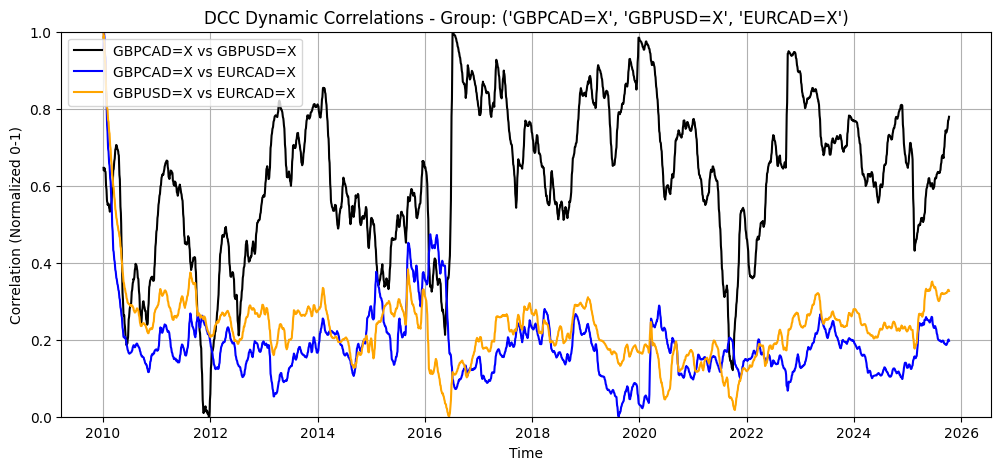

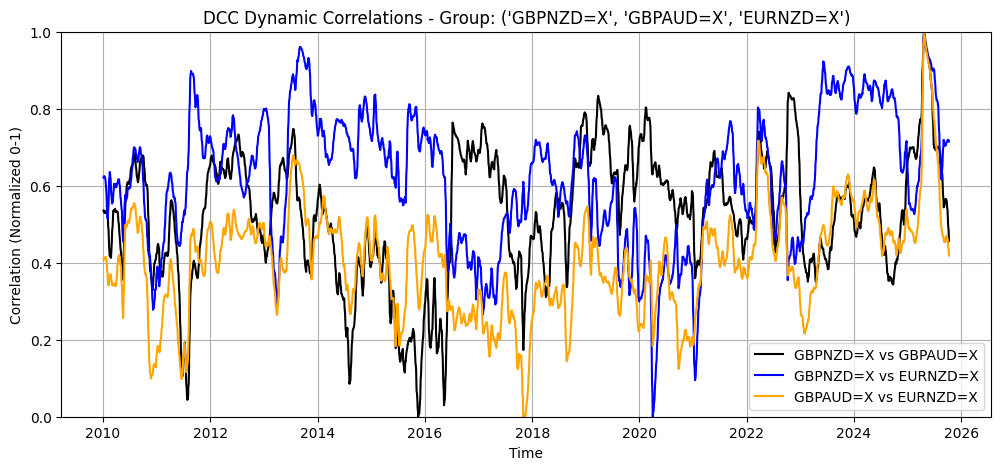

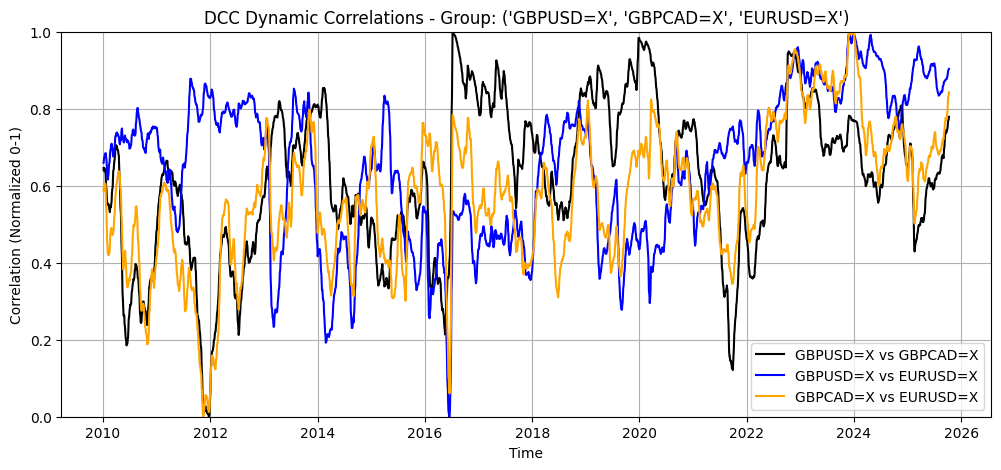

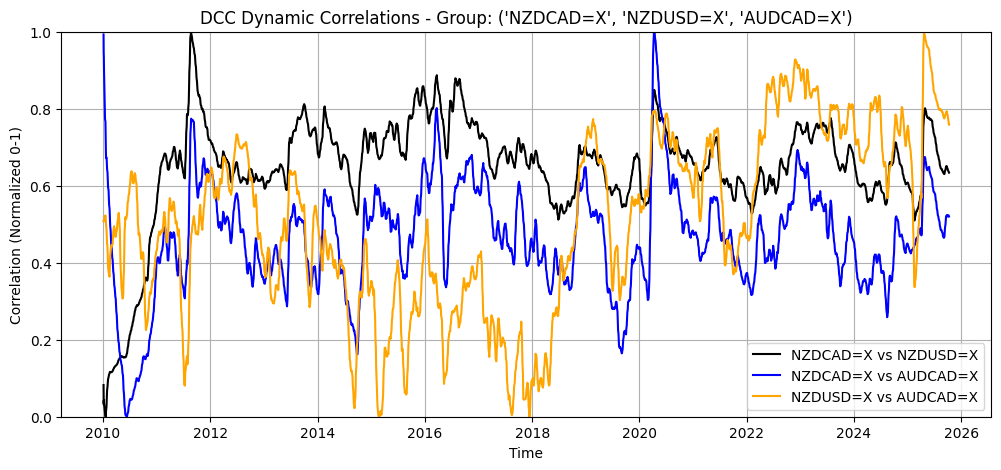

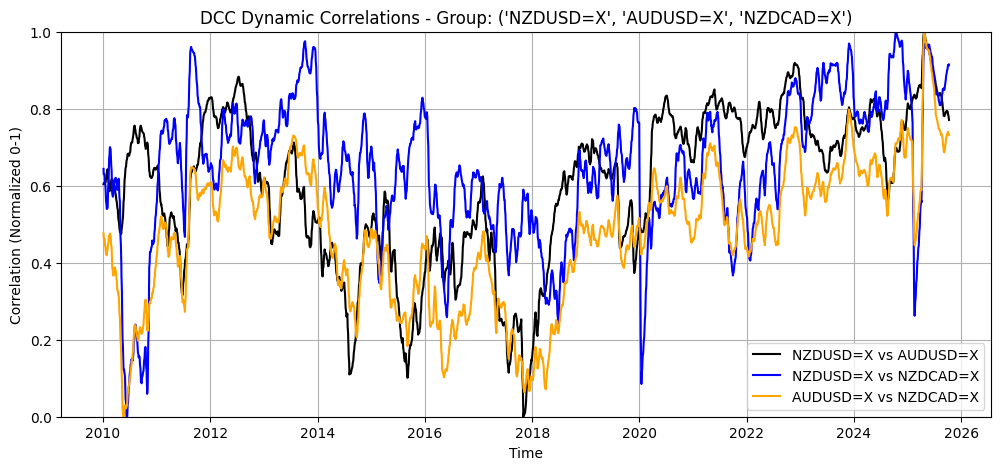

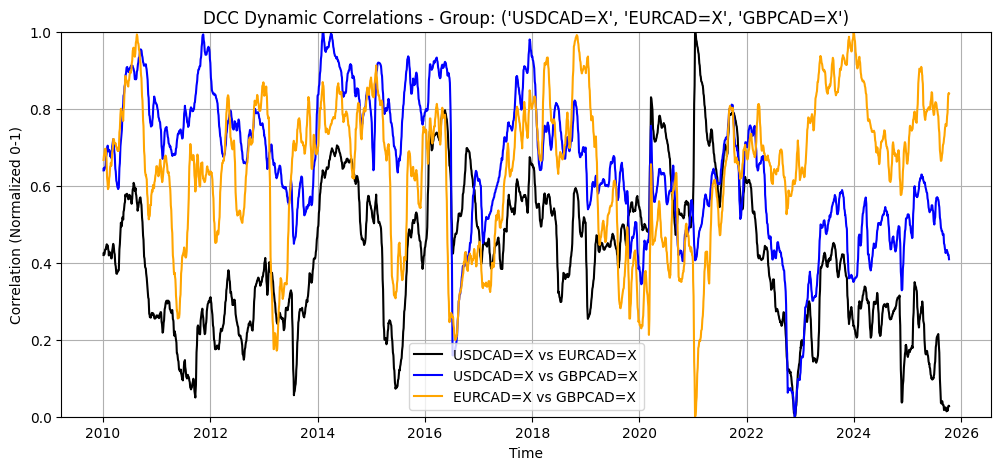

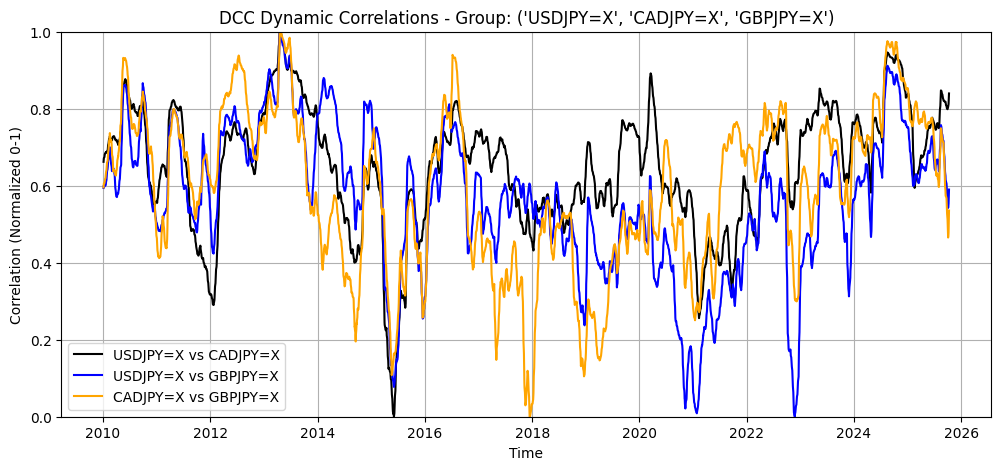

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 2️⃣ z-standardize function
# -------------------------------
def z_standardize(df):
    return (df - df.mean()) / df.std()

# -------------------------------
# 3️⃣ Function to plot DCC correlations with optional normalization
# -------------------------------
def plot_group_dcc_overlapping(
    garch_std_resid,
    group_key,
    smooth_window=10,
    normalize=False  # True = 0-1 scale, False = actual correlation
):
    """
    garch_std_resid: dict of standardized residuals per group
    group_key: group to plot
    smooth_window: rolling mean smoothing window
    normalize: if True, scale to 0-1; if False, keep true correlation (-1 to 1)
    """
    std_resid_df = garch_std_resid[group_key]

    # z-standardize residuals
    eps_df = z_standardize(std_resid_df)
    eps = eps_df.values
    asset_names = std_resid_df.columns
    N = len(asset_names)

    # Fit DCC
    dcc_model = DCC_local()
    Rt = dcc_model.fit(eps)

    plt.figure(figsize=(12,5))
    colors = ['black', 'blue', 'orange']  # updated color scheme

    # Plot all 3 pairs
    pairs = [(0,1), (0,2), (1,2)]
    for idx, (i,j) in enumerate(pairs):
        corr_line = Rt[:, i, j]

        # Smooth correlation using rolling mean
        corr_smooth = pd.Series(corr_line).rolling(window=smooth_window, min_periods=1).mean()

        # Normalize if requested
        if normalize:
            corr_norm = (corr_smooth - corr_smooth.min()) / (corr_smooth.max() - corr_smooth.min())
            plt.plot(std_resid_df.index, corr_norm, label=f"{asset_names[i]} vs {asset_names[j]}", color=colors[idx])
        else:
            plt.plot(std_resid_df.index, corr_smooth, label=f"{asset_names[i]} vs {asset_names[j]}", color=colors[idx])

    plt.title(f"DCC Dynamic Correlations - Group: {group_key}")
    plt.xlabel("Time")
    plt.ylabel("Correlation" + (" (Normalized 0-1)" if normalize else " (-1 to 1)"))
    plt.ylim((0,1) if normalize else (-1,1))
    plt.grid(True)
    plt.legend()
    plt.show()

# -------------------------------
# 4️⃣ Example usage: loop over all groups
# -------------------------------
for group_key in garch_std_resid.keys():
    print("\n\n")
    # Set normalize=True for pattern recognition, False for true correlation
    plot_group_dcc_overlapping(garch_std_resid, group_key, smooth_window=10, normalize=True)
